# Introduction

The following project is focused on **Covid-19** to use NLP and other machine learning algorithms learnedin thiscourse to develop atoolthat can text-mine this database of research articles to gain useful insights about COVID-19 and how we might beable to tackle the outbreak, contain the spreadand flatten the curve. 


### Table of Content

   - Data Cleaning
       - abstract text cleaning for all articles
       - abstract text cleaning for covid-19 related articles.
   - Exploratory Data Analysis
       -  Reading full text from json files
       -  word clouds
       -  Incubation periods
       -  Possible casuses of transmission
       -  Affected organs
   - Model selection and fitting to data


*   **Logic: I get the labels from k-means, without any meaning to them. Then use Topic Modeling (LDA) on each cluster to get the keywords in order to put more meaning to each cluster. Finally, we do a manual analysis of each cluster to see what articles cluster together.**



       - Unsupervised Model: K-means (Document clustering), cluster the entire dataset into 10 groups, then feed each group to LDA model get topics of each cluster.
       - Unsupervised Model: LDA (Topic modeling), get 5 dominate topics for each cluster.
 
-  Deriving insights about policy and guidance to tackle the outbreak based on modelfindings

In [0]:
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import string
from collections import OrderedDict
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import HashingVectorizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

%matplotlib inline 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read data

In [0]:
# load the meta data from the CSV file 
df=pd.read_csv('metadata.csv', usecols=['title','abstract','authors','doi','publish_time'])
print (df.shape)

(45774, 5)


# Data Cleaning

In this section, the two different datasets are cleaned by removing punctuations, stopwords, and unnecessary spaces. In addition, all words are made lowercase.
The subsections below are:

    1.1 All articles abstract text
    
    1.2 Covid-19 related articles abstract text

In [0]:
def remove_spaces(text):
    """
    get rid of  miscellaneous items as well as trailing and leading white spaces
    """
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'-','',text)
    
    return text

In [0]:
#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#drop NANs 
df=df.dropna()

# convert abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()

# #add word count columns for both abstract text 
# df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.strip().split()))

#remove punctuation from each text
df['abstract'] = df['abstract'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

#cleaning
df['abstract'] = df['abstract'].apply(remove_spaces)

#drop unnecessary columns
df.drop(['doi', 'publish_time'], axis=1, inplace=True)

In [0]:
print(df.shape)
df.head()

(34809, 3)


,title,abstract,authors
0,SIANN: Strain Identification by Alignment to N...,nextgeneration sequencing is increasingly bein...,Samuel Minot; Stephen D Turner; Krista L Ternu...
1,Spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,Lin WANG; Xiang Li
2,Sequencing of the human IG light chain loci fr...,germline variation at immunoglobulin gene ig l...,Corey T Watson; Karyn Meltz Steinberg; Tina A ...
3,Bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...,Sofia Morfopoulou; Vincent Plagnol
4,Mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...,Stephen P Velsko; Jonathan E Allen


## select articles related to Covid-19 virus

I filtered out some articles which does not related covid-19. The left articles should be considered all about covid-19 (done by keywords extraction method).

In [0]:
covid_synonyms=['coronavirus','Covid-19','Corona virus','COVID 19','covid-19', 'Coronavirus', 'cov-2',  'hcov', '2019-ncov']
covid_df = df[df['abstract'].str.contains('|'.join(covid_synonyms))]

In [0]:
print(covid_df.shape)
covid_df.head()

(7032, 3)


,title,abstract,authors
8,MERS-CoV recombination: implications about the...,recombination is a process that unlinks neighb...,Gytis Dudas; Andrew Rambaut
13,Productive infection of field strains of avian...,the avian coronavirus infectious bronchitis vi...,Yueting Zhang; Gary Whittaker
37,Lung epithelial cells have virus-specific and ...,abstractthe severity and outcome of respirator...,James T. VanLeuven; Benjamin J. Ridenhour; Cra...
39,Epidemiological and ecological modelling revea...,abstractrespiratory tract infections rti are r...,Abigail L. Coughtrie; Denise E. Morris; Rebecc...
40,Spike-based phylogenetically defined clades wi...,abstracttaxonomic classification for the coron...,Gary R. Whittaker; Nicole M. André; Jean Kaoru...


## remove stop words

I have added some new words, these words are stored on a list and they can be considered as stopwords because they appeared so often and doesnt actually help us in further data mining analysis, should remove them.

In [0]:
other_stopwords = [ 'data','case','cases','finding','findings','number','estimate','evidence','license', 'preprint', 'copyright', 
                   'http', 'doi', 'peer', 'reviewed', 'org', 'https',  'author', 'figure', 'rights', 'show','effect','period','one','two',
                   'specification','year','important','four','three','five','related','new','provide','furthermore','section','use',
                   'column','including','level','following','first','second','third','indicate','made','support','main','area',
                   'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 'many',
                   'background', 'methods', 'introduction', 'conclusions', 'results','figure','include','even',
                   'purpose' ,'objective','materials', 'discussions','methodology','result analysis','q', 'doi',  'et', 'al', 
                   'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  
                   'eq', 'si', 'cc','may','way','ways','eg','key']

custom_stopwords = []
custom_stopwords = list(set(stopwords.words('english'))) + other_stopwords

df['abs_without_stopwords'] = df['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stopwords)]))
covid_df['abs_without_stopwords'] = covid_df['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stopwords)]))

In [0]:
df.head()

,title,abstract,authors,abs_without_stopwords
0,SIANN: Strain Identification by Alignment to N...,nextgeneration sequencing is increasingly bein...,Samuel Minot; Stephen D Turner; Krista L Ternu...,nextgeneration sequencing increasingly study s...
1,Spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,Lin WANG; Xiang Li,emerging disease infectious epidemic caused ne...
2,Sequencing of the human IG light chain loci fr...,germline variation at immunoglobulin gene ig l...,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,germline variation immunoglobulin gene ig loci...
3,Bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...,Sofia Morfopoulou; Vincent Plagnol,deep sequencing clinical samples established t...
4,Mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...,Stephen P Velsko; Jonathan E Allen,developing reconstruct transmission histories ...


In [0]:
covid_df.head()

,title,abstract,authors,abs_without_stopwords
8,MERS-CoV recombination: implications about the...,recombination is a process that unlinks neighb...,Gytis Dudas; Andrew Rambaut,recombination process unlinks neighbouring loc...
13,Productive infection of field strains of avian...,the avian coronavirus infectious bronchitis vi...,Yueting Zhang; Gary Whittaker,avian coronavirus infectious bronchitis virus ...
37,Lung epithelial cells have virus-specific and ...,abstractthe severity and outcome of respirator...,James T. VanLeuven; Benjamin J. Ridenhour; Cra...,abstractthe severity outcome respiratory viral...
39,Epidemiological and ecological modelling revea...,abstractrespiratory tract infections rti are r...,Abigail L. Coughtrie; Denise E. Morris; Rebecc...,abstractrespiratory tract infections rti respo...
40,Spike-based phylogenetically defined clades wi...,abstracttaxonomic classification for the coron...,Gary R. Whittaker; Nicole M. André; Jean Kaoru...,abstracttaxonomic classification coronaviridae...


## lemmatising

Lemmatisation - Lemmatisation is a process of reducing words into their lemma or dictionary. It takes into account the meaning of the word in the sentence. For eg: beautiful and beautifully are lemmatised to beautiful and beautifully respectively without changing the meaning of the words. But, good, better and best are lemmatised to good since all the words have similar meaning.

In [0]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatising (text):
    #tokenize sentence first
    words_in_each_text = word_tokenize(text)
    #perform lemmatising
    final = [lemmatizer.lemmatize(word) for word in words_in_each_text]
    result_string = ' '.join(final)
    return result_string

In [0]:
df['abs_with_lemmer'] = df['abs_without_stopwords'].apply(lemmatising)
covid_df['abs_with_lemmer'] = covid_df['abs_without_stopwords'].apply(lemmatising)

In [0]:
df.head()

,title,abstract,authors,abs_without_stopwords,abs_with_lemmer
0,SIANN: Strain Identification by Alignment to N...,nextgeneration sequencing is increasingly bein...,Samuel Minot; Stephen D Turner; Krista L Ternu...,nextgeneration sequencing increasingly study s...,nextgeneration sequencing increasingly study s...
1,Spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,Lin WANG; Xiang Li,emerging disease infectious epidemic caused ne...,emerging disease infectious epidemic caused ne...
2,Sequencing of the human IG light chain loci fr...,germline variation at immunoglobulin gene ig l...,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,germline variation immunoglobulin gene ig loci...,germline variation immunoglobulin gene ig locu...
3,Bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...,Sofia Morfopoulou; Vincent Plagnol,deep sequencing clinical samples established t...,deep sequencing clinical sample established to...
4,Mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...,Stephen P Velsko; Jonathan E Allen,developing reconstruct transmission histories ...,developing reconstruct transmission history vi...


In [0]:
covid_df.head()

,title,abstract,authors,abs_without_stopwords,abs_with_lemmer
8,MERS-CoV recombination: implications about the...,recombination is a process that unlinks neighb...,Gytis Dudas; Andrew Rambaut,recombination process unlinks neighbouring loc...,recombination process unlinks neighbouring loc...
13,Productive infection of field strains of avian...,the avian coronavirus infectious bronchitis vi...,Yueting Zhang; Gary Whittaker,avian coronavirus infectious bronchitis virus ...,avian coronavirus infectious bronchitis virus ...
37,Lung epithelial cells have virus-specific and ...,abstractthe severity and outcome of respirator...,James T. VanLeuven; Benjamin J. Ridenhour; Cra...,abstractthe severity outcome respiratory viral...,abstractthe severity outcome respiratory viral...
39,Epidemiological and ecological modelling revea...,abstractrespiratory tract infections rti are r...,Abigail L. Coughtrie; Denise E. Morris; Rebecc...,abstractrespiratory tract infections rti respo...,abstractrespiratory tract infection rti respon...
40,Spike-based phylogenetically defined clades wi...,abstracttaxonomic classification for the coron...,Gary R. Whittaker; Nicole M. André; Jean Kaoru...,abstracttaxonomic classification coronaviridae...,abstracttaxonomic classification coronaviridae...


# Exploratory Data Analysis

In this section, all exploratory data analysis will be performed, I used full text for some specific topics instead of using abstract.
The reason why I decided to use full text to explore some facts is because full text may give us more useful and correct data information than abstract text.
Thus I have created a dataframe called **"df_full_text"**, which has two columns: abstract and full_text. 

The data read from json file provided by course instructor, those json files can be downloaded from here:
https://drive.google.com/drive/folders/161uYI2GwTXyajJti3SkP6N4R3DsiB3jq

## Read full text from Json files

In [0]:
dirs_=["biorxiv_medrxiv/biorxiv_medrxiv",
"comm_use_subset/comm_use_subset",
"noncomm_use_subset/noncomm_use_subset",
"custom_license/custom_license"]
data_=list()
for dir_ in dirs_:
    for filename in tqdm(os.listdir(dir_)):

        x=str(dir_)+'/'+str(filename)

        with open(x) as file:
            data=json.loads(file.read())

        #take out the data from the json format
        meta_data=data['metadata']
        abstract=data['abstract']
        abstract_text=""
        for text in abstract:
            abstract_text+=text['text']+" "
        body_text=data['body_text']
        full_text=""
        for text in body_text:
            full_text+=text['text']+" "
        back_matter=data['back_matter']
        #store everything to a dataframe
        data_.append([abstract_text,full_text])

df_full_text=pd.DataFrame(data_,columns=['abstract','full_text'])

100%|██████████| 20657/20657 [00:31<00:00, 658.58it/s]


Simple cleaning procedure, as follows: drop duplicates, drop NAN, lower-case all words, remove punctuations, remove leading and trailing spaces.

In [0]:
#drop duplicates
df_full_text = df_full_text.drop_duplicates(subset='full_text', keep="first")

#drop NANs 
df_full_text=df_full_text.dropna()

# convert abstracts to lowercase
df_full_text["full_text"] = df_full_text["full_text"].str.lower()


#remove punctuation from each text
df_full_text['full_text'] = df_full_text['full_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

#remove trailing and leading spaces
df_full_text['full_text'] = df_full_text['full_text'].apply(remove_spaces)

Same procedure as remove stopwords in abstract text, but here I decided not to perform lemmatising because we dont actually need to vectorize full text in later, I only do some exploratory data analysis based on full text. Thus, remove stopwords is enough.

In [0]:
# nltk stopwords list
other_stopwords = [ 'data','case','cases','finding','findings','number','estimate','evidence','license', 'preprint', 'copyright', 
                   'http', 'doi', 'peer', 'reviewed', 'org', 'https',  'author', 'figure', 'rights', 'show','effect','period','one','two',
                   'specification','year','important','four','three','five','related','new','provide','furthermore','section','use',
                   'column','including','level','following','first','second','third','indicate','made','support','main','area',
                   'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 'many',
                   'background', 'methods', 'introduction', 'conclusions', 'results','figure','include','even',
                   'purpose' ,'objective','materials', 'discussions','methodology','result analysis','q', 'doi',  'et', 'al', 
                   'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  
                   'eq', 'si', 'cc','may','way','ways','eg','key']

custom_stopwords = []
custom_stopwords = list(set(stopwords.words('english'))) + other_stopwords
df_full_text['fulltext_without_stopwords'] = df_full_text['full_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stopwords)]))

## word cloud

Starting with word clouds, which shows a series of words with varying sizes that are proportional to the word's frequency in the dataset.
First word cloud is getting from full text dataset, second is from all abstract text, and third word cloud is from covid-19 related article abstract.

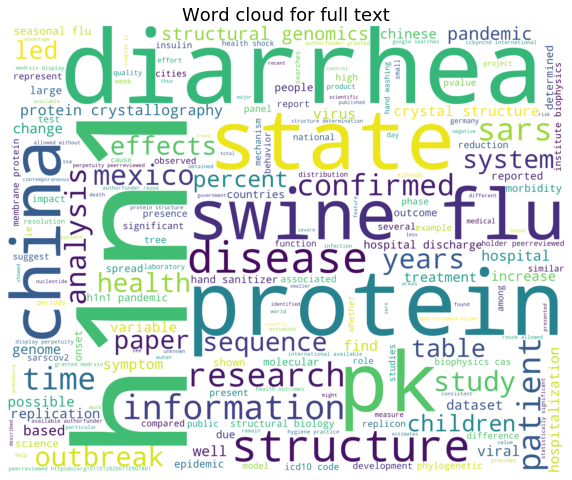

In [0]:
text = df_full_text['fulltext_without_stopwords'].values
wordcloud = WordCloud(width = 5000, height = 4000, background_color="white").generate(str(text))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word cloud for full text',fontsize=18)
plt.axis("off")
plt.show()

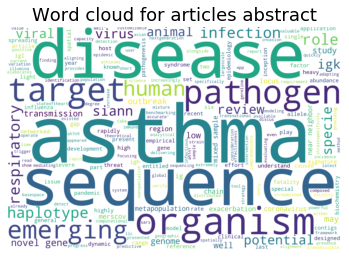

In [0]:
# create wordcloud on the lemmtised text
text = df['abs_with_lemmer'].values
wordcloud = WordCloud(width = 3000, height = 2000, background_color="white").generate(str(text))
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word cloud for articles abstract',fontsize=18)
plt.axis("off")
plt.show()

Word cloud for those articals related covid-19 virus

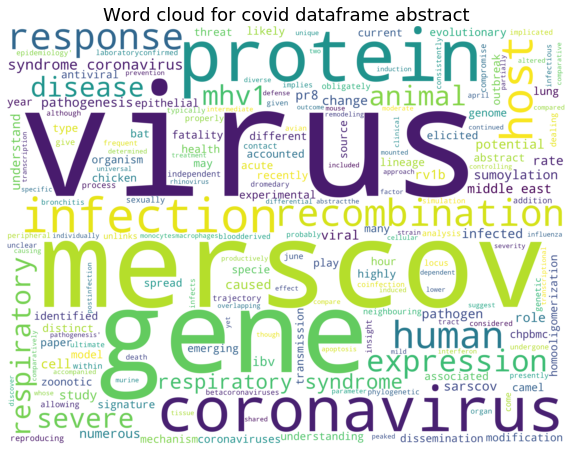

In [0]:
text = covid_df['abs_with_lemmer'].values
wordcloud = WordCloud(width = 4000, height = 3000, background_color="white").generate(str(text))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word cloud for covid dataframe abstract',fontsize=18)
plt.axis("off")
plt.show()

## Virus Symptoms

In this section, I have predetermined some potential symptoms which them may related to Covid-19. Then I will go through every document (full text), to see if some articles mention these symptom key words, and count the frequency of each of these symptoms.

In [0]:
symptoms = ['confusion', 'malaise','arthralgia', 'bleeding', 'swelling', 'weight gain',  
             'rash','sore throat', 'headache', 'fatigue', 'itching', 'depression', 
              'mania','dyspnea', 'anxiety', 'edema', 'weight loss', 'vomiting', 'discharge',
              'cough', 'diarrhea', 'fever','cold',  'rhinitis', 'sore throat', 'bronchitis', 'bronchiolitis', 'pneumonia']
symptom_count = dict((symptom,0) for symptom in symptoms)

for symptom in symptom_count:
    for abstract in df_full_text['full_text']:
        if str(symptom) in abstract:
            symptom_count[symptom] += 1

symptom_count_sorted = OrderedDict(sorted(symptom_count.items(), key=lambda x: x[1]))
print(symptom_count_sorted)

OrderedDict([('arthralgia', 498), ('weight gain', 791), ('rhinitis', 943), ('anxiety', 1055), ('malaise', 1077), ('confusion', 1126), ('bleeding', 1312), ('fatigue', 1328), ('mania', 1344), ('swelling', 1354), ('sore throat', 1442), ('itching', 1509), ('bronchiolitis', 1521), ('dyspnea', 1592), ('depression', 1790), ('rash', 1850), ('headache', 1944), ('weight loss', 1977), ('vomiting', 2517), ('bronchitis', 2565), ('edema', 2749), ('discharge', 3480), ('diarrhea', 4999), ('cough', 5029), ('cold', 5489), ('pneumonia', 8148), ('fever', 9771)])


C:\Users\Jayde\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


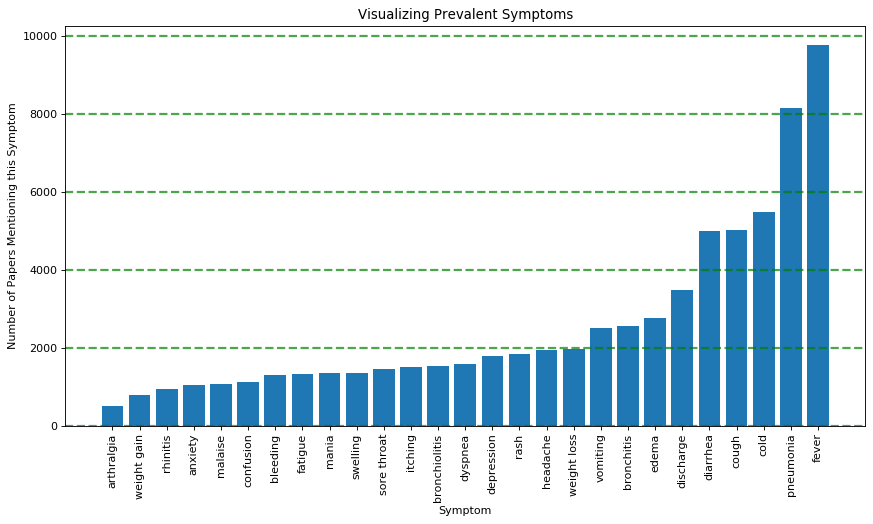

In [0]:
loc = np.arange(len(symptom_count_sorted))
width = 0.35
fig = plt.figure(num=None, constrained_layout=True, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
ax.bar(symptom_count_sorted.keys(),symptom_count_sorted.values())
ax.set_xticks(loc, tuple(symptoms))
ax.grid(color='green', linestyle='--', linewidth=2, axis='y', alpha=0.7)
ax.set_ylabel('Number of Papers Mentioning this Symptom')
ax.set_xlabel('Symptom')
ax.set_title('Visualizing Prevalent Symptoms')
plt.xticks(rotation=90)
plt.show()

From the bar chart above, we can see fever, pnenumonia, cold, cough, discharge  and diarrhea have most frequency count, which indicated that covid-19, cov-2, sars may all have same symptoms (flu like symptoms). 

## Incubation periods

This cell below will search all synonyms of 'incubation' in nltk wordnet, results will be stored at a list. I will then use this list to check if an article mentioned any of synonyms of incubation.

In [0]:
synonyms=[]
for syn in wordnet.synsets("incubation"):
    for word in syn.lemma_names():
        if word not in synonyms:
        	synonyms.append(word)
#after get a list of synonyms of 'incubation', create a datafram that all articles inside it should mentioned 'incubation'
incubation_df=df_full_text[df_full_text['fulltext_without_stopwords'].str.contains('|'.join(synonyms))]

This dataframe contains incubation related articles (full text).

In [0]:
incubation_df.head()

,abstract,full_text,fulltext_without_stopwords
2,,the 2019ncov epidemic has spread across china ...,2019ncov epidemic spread across china 24 count...
4,Nipah Virus (NiV) came into limelight recently...,nipah is an infectious negativesense singlestr...,nipah infectious negativesense singlestranded ...
9,Post-transcriptional gene silencing (PTGS) is ...,sirna without relying on plant transformation ...,sirna without relying plant transformation how...
11,Background: As the number of suspected and con...,despite its humble origins as a cluster of cas...,despite humble origins cluster restricted wuha...
12,Human astroviruses are small nonenveloped viru...,humans astroviruses hastvs belong to genus mam...,humans astroviruses hastvs belong genus mamast...


In [0]:
result_period=[]
texts=incubation_df['fulltext_without_stopwords']
for i in texts:
  for text in i.split(". "):
          if 'incubation' in text:
              results=re.findall(r" \d{1,2} day",text)
              if len(results)!=0:
                  result_period.append(results)

In [0]:
#extracting incubation periods from data
incubation_period=[]
for samples in result_period:
	for sam in samples:
		for data in sam.split(" "):
				incubation_period.append(float(data))

incubation_period_df=pd.DataFrame(incubation_period)

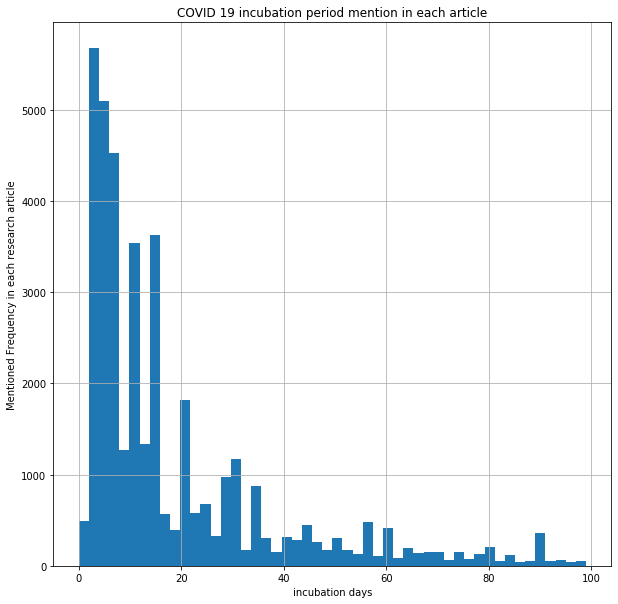

In [0]:
#plot
hist=incubation_period_df.hist(bins=50,figsize=(10,10))
plt.ylabel('Mentioned Frequency in each research article')
plt.xlabel('incubation days')
plt.title('COVID 19 incubation period mention in each article')
plt.show()

The bar chart shows that the average incubation period lies between the range 0-20 days at most. There maybe a long tail of this graph, it would probably casued by some noisy extractions. 

As WHO stated, the incubation period is 14 days of covid-19 as of 24th March 2020. So our insights provide a range within this period approximately. 

## Causes of Transmission

Searching for synonyms of transmission and store them in a list.

In [0]:
transmission_synonyms=["spread","transmit","transmission","transmitted"]
for syn in wordnet.synsets("transmission"):
    for name in syn.lemma_names():
        if name not in transmission_synonyms:
            transmission_synonyms.append(name)

for syn in wordnet.synsets("spread"):
    for name in syn.lemma_names():
        if name not in transmission_synonyms:
            transmission_synonyms.append(name)

The cell below will extrach article which related to transmission, to a list. 

In [0]:
transmission_data=[]
#looping through each paper
for texts in df_full_text['fulltext_without_stopwords']:
    #looping through each sentence
    for tex in texts.split(". "):
        #checking if my keyswords is present in those sentences or not
        for word in transmission_synonyms:
            if word in tex:
                transmission_data.append(tex)

In [0]:
punctuations='''!()[,]{\};:'"<>./?@#$%^&*_~'''
word_bucket={}
string=""

for lines in transmission_data:
    for words in lines.split(" "):
        if words.isalpha() == False:
            #remove punctuaions so that regex line dont get error message
            for chrs in words:
                if chrs in punctuations:
                    words=words.replace(chrs,"")
            if len(re.findall("\d|transmi|also",words))==0 and len(words)>3:
                lexemes=re.findall(words,string)

                if words not in word_bucket.keys() and len(lexemes)==0:
                    word_bucket[words]=1
                    string=string+" "+words
                else:
                    word_bucket[words]=word_bucket[words]+1



analytics={}
for keys in word_bucket:
    if int(word_bucket[keys])>4:
        analytics[keys]=word_bucket[keys]

I have listed some possible transimission approches, like I did in visulaization on symptoms part, I will search full text to extract keywords count. Then visualize it in a bar chart.

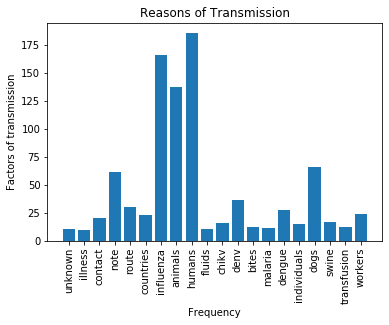

In [0]:
common_words=["population","unknown","illness","sars-cov","fecal-oral","mers-cov","family","contact","coronavirus","droplets","zoonotic","note",
"faecal-oral","route","countries","influenza","coronaviruses","animals","human-to-human","food","bats","hosts","humans","fever","aerosols","patients",
"fluids","infections","arthropod-borne","chikv","flaviviridae","ticks","denv","tick-borne","pathogens","vector-borne","bites","person-to-person",
"ferrets","zikv","water","malaria","dengue","individuals","camels","bat-borne","dogs","swine","stis","arthropods","flaviviruses","mosquitoes",
"transfusion","within-host","rodents","schistosomiasis","healthcare-associated","workers","henipaviruses","horses","saliva","pigs","fomites","agents",
"persons","genus"]

frequency=[]
countword=[]
for i in common_words:
    if i in analytics.keys():
        countword.append(i)
for i in countword:
    if i in analytics.keys():
        frequency.append(analytics[i])
    else:
        common_words.remove(i)

plt.bar(countword[0:20],frequency[0:20])
plt.xlabel("Frequency")
plt.ylabel("Factors of transmission")
plt.title("Reasons of Transmission")
plt.xticks(rotation=90)
plt.show()

The bar graph with respect to the of different factors for transmission of the COVID-19 has been plotted. Along with the frequency of how many articles have had supported each factors. 

It is clear from the above graphs, human-to-human and influenza, that is the virus is mostly transmitted via coughing, sneezing. Apart from it, its mainly transmitted via hosts (animal) dogs, bats. 

The virus that causes similar symptoms are SARS and other flu like virus. 

## Affected organs

In this section, I will analyze potential organs which would possibly affect by covid-19, the approch is similar in visualization symptoms part, I will search whole full text data, extract keywords count on each of them, visualize in a bar chart.

In [0]:
organs_list = ['endocrine system','mesentery','the brainstem', 'lymphatic vessel', 'mammary glands', 'lymphatic system', 
               'peripheral nervous system', 'cerebrum', 'adrenal glands', 'vulva', 'subcutaneous tissue', 
               'choroid plexus', 'ovaries', 'interstitium', 'salivary glands','larynx', 
               'cerebellum', 'nasal cavity', 'teeth', 'veins', 'esophagus','diaphragm', 'large intestine',
               'capillaries','the spinal cord', 'cornea', 'tonsils','arteries', 'duodenum', 'nerves',
               'respiratory system','retina', 'ileum', 'prostate', 'tongue','iris','thymus', 'pancreas', 
               'stomach',  'pharynx','kidneys',  'small intestine',
            'trachea','lymph node', 'spleen',
               'lungs','bronchi', 'liver']

In [0]:
organ_count = dict((organ,0) for organ in organs_list)

for symptom in organ_count:
    for text in df_full_text['full_text']:
        if str(symptom) in text:
            organ_count[symptom] += 1

organ_count_sorted = OrderedDict(sorted(organ_count.items(), key=lambda x: x[1]))
print(organ_count_sorted)

OrderedDict([('endocrine system', 116), ('mesentery', 166), ('the brainstem', 174), ('lymphatic vessel', 177), ('mammary glands', 179), ('lymphatic system', 184), ('peripheral nervous system', 204), ('cerebrum', 206), ('adrenal glands', 216), ('vulva', 217), ('subcutaneous tissue', 219), ('choroid plexus', 230), ('ovaries', 249), ('interstitium', 380), ('salivary glands', 402), ('larynx', 406), ('cerebellum', 457), ('nasal cavity', 474), ('teeth', 476), ('veins', 485), ('esophagus', 490), ('diaphragm', 511), ('large intestine', 534), ('capillaries', 550), ('the spinal cord', 572), ('cornea', 575), ('tonsils', 579), ('arteries', 582), ('duodenum', 599), ('nerves', 655), ('respiratory system', 708), ('retina', 719), ('ileum', 804), ('prostate', 869), ('tongue', 871), ('iris', 910), ('thymus', 946), ('pancreas', 959), ('stomach', 1337), ('pharynx', 1403), ('kidneys', 1424), ('small intestine', 1547), ('trachea', 2794), ('lymph node', 2849), ('spleen', 3561), ('lungs', 4067), ('bronchi', 5

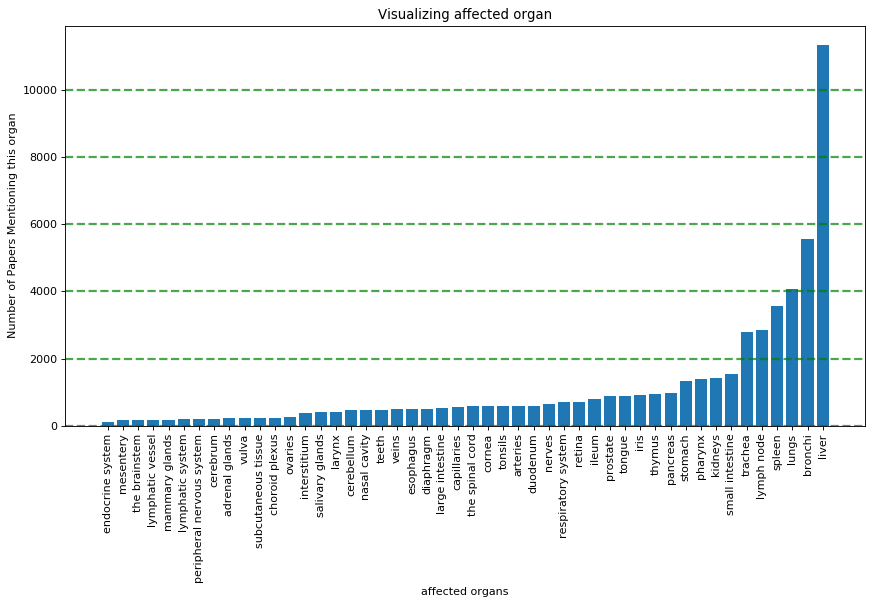

In [0]:
loc = np.arange(len(organ_count_sorted))
width = 0.35
fig = plt.figure(num=None, constrained_layout=True, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
ax.bar(organ_count_sorted.keys(),organ_count_sorted.values())
ax.set_xticks(loc, tuple(organs_list))
ax.grid(color='green', linestyle='--', linewidth=2, axis='y', alpha=0.7)
ax.set_ylabel('Number of Papers Mentioning this organ')
ax.set_xlabel('affected organs')
ax.set_title('Visualizing affected organ')
plt.xticks(rotation=90)
plt.show()

The above bar chart illustrated that, liver, bronchi, lungs, spleen may affected most by covid-19, they all belongs to a system: Respiratory infection.

# Unsupervised Learning Model 1: K-Means clustering 

    Document Clustering:
    
    The task of this project is organizing a collection of
    documents, whose classification is unknown, into meaningful groups 
    (clusters) that are homogeneous according to some notion of proximity 
    (distance or similarity) among documents.

**Goal for project:**

**(1)** From instructor provided dataset: metadata.csv, it contains a large amount of literature articles about covid-19 and other viruses, and thus, it is necessary to use a **unspervised learning model**(do not have labels) to cluster them into some groups. By doing so, we can cluster similar articles together to make it easier for people to find relevant research articles later on. After get the label from K-means, I will also perform multiclass classification task by using three machine learning algorithms, to find out which vectorize method better.(doc2vec VS tf-idf)



 **Steps:**
*   (1) Document Clustering should give some clusters of documents that will be useful for finding facts about virus

*   (2) Then delivers label to perform multi-class classificaiton tasks by using three models.

      1.   Logistic Regresssion
      2.   Decision Tree
      3.   XGBoost


**feature selection and processing:**

Numeric representation of text documents is necessary step before implement any machine learning algorithm, I choose to use two text vectorized methods for my project:


1.   Doc2vec
2.   TF-IDF

Since above two vectorize methods usually give us high dimension results, I will use **PCA** to perform reduce the dimentionality to 3D, becasue we cannot visualize more than 3 dimensions.


## Pros and cons for K-Means

**Pros:**

*   Relatively simple to implement.
*   Scales to large data sets.
*   K means guarantees convergence.
*   Generalizes to clusters of different shapes and sizes, such as elliptical clusters.
*   Easily adapts to new examples.

**Cons:**

*   Hard to selection K value (number of clusters)

*   Centroids can be dragged by outliers, or outliers might get their own cluster instead of being ignored. Consider removing or clipping outliers before clustering.
*   If start at a bad centroid, k means probably has chance to get sub-optimal soulutions.


## Doc2Vec Features

Doc2Vec is one of the great mechanisims for representation of text in documents and it is based on word2vec model. 

The goal of doc2vec is to create a numeric representation of a document, regardless of its length. But unlike words, documents do not come in logical structures such as words, so the another method has to be found.

To conclude, if we have some document related tasks — DOC2VEC may be great model for us!

In [0]:
def doc2vec():
    document_tagged = []
    tagged_count = 0
    for _ in df['abs_with_lemmer'].values:
        document_tagged.append(gensim.models.doc2vec.TaggedDocument(_,[tagged_count]))
        tagged_count +=1 
    d2v = Doc2Vec(document_tagged)
    d2v.train(document_tagged,epochs=d2v.epochs,total_examples=d2v.corpus_count)
    return d2v.docvecs.vectors_docs

In [0]:
#encoding abstract text by doc2vec features
%%time
doc2vec_data = doc2vec()

CPU times: user 3min 43s, sys: 8.75 s, total: 3min 51s
Wall time: 2min 19s


In [0]:
doc2vec_features = pd.DataFrame(data=doc2vec_data)

print(doc2vec_features.shape)
doc2vec_features.head()

(34809, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.056620,0.255261,0.032520,0.086884,0.258996,-0.115424,-0.208052,-0.287485,0.519751,0.240483,0.154163,-0.077798,-0.007952,-0.076399,-0.166650,-0.119795,-0.281718,0.359973,0.253710,-0.238584,0.439430,-0.337459,0.086046,0.016386,0.109176,-0.072759,0.098123,-0.368491,0.078640,0.415013,-0.307584,-0.064409,-0.320885,0.037863,0.050513,0.157273,-0.171270,0.139525,-0.173258,-0.044481,...,-0.031381,-0.027929,-0.205987,0.084008,0.055309,0.069894,0.015090,0.022372,-0.187977,-0.137359,0.135716,-0.145145,0.219073,-0.000818,-0.207902,-0.074525,-0.164030,0.101146,-0.053108,0.045662,0.169784,-0.010772,-0.097630,-0.093456,0.191239,0.012607,-0.088380,0.212192,0.066242,-0.277571,-0.143119,-0.188478,0.186016,0.122707,-0.265834,0.188850,0.165816,-0.293353,0.280396,-0.001592
1,-0.088456,0.166744,0.210955,-0.045630,0.036043,0.023745,0.671440,0.098650,-0.147050,0.061708,0.221195,0.082180,0.003315,0.106049,-0.382830,-0.029311,-0.084550,0.132824,0.431478,0.070202,0.040151,-0.063162,0.228186,0.048286,-0.231514,-0.268145,0.107808,-0.437047,-0.038794,0.245946,-0.114646,0.041647,-0.119291,-0.098327,-0.114004,-0.028984,-0.108480,0.101368,-0.244999,-0.214337,...,0.252960,-0.057687,0.069627,-0.066306,-0.002415,-0.044357,-0.149441,0.285904,-0.061006,0.023684,-0.124497,0.143210,0.029517,-0.277617,-0.398380,0.153644,-0.124725,-0.112769,-0.051397,0.011028,0.279482,0.010717,-0.008698,0.158119,-0.123661,-0.184449,-0.181987,-0.089847,-0.206513,-0.204166,0.096626,-0.217391,-0.050721,-0.080144,0.108087,0.202529,0.139179,-0.062108,-0.315463,0.077617
2,0.112996,-0.360566,0.106383,-0.193133,0.139478,-0.160411,0.227257,0.039650,0.114814,0.065543,-0.016006,-0.022184,-0.014782,-0.319477,0.038987,-0.106550,-0.069533,-0.047204,0.153959,0.359009,0.018135,0.196638,0.015465,0.067333,0.100469,0.365637,-0.101558,-0.304783,0.245566,0.015733,-0.072170,0.239421,-0.353813,-0.247557,-0.077866,0.128501,-0.021139,0.443619,-0.301082,-0.351438,...,0.270698,-0.213997,-0.115823,-0.653251,-0.383441,-0.252316,0.192650,0.374721,0.207313,0.099938,-0.188622,0.298254,0.008890,-0.259661,-0.206582,0.381951,0.079463,0.058465,0.100342,0.052418,0.256579,0.137616,-0.019561,0.419347,-0.142452,-0.335912,0.187939,0.143606,-0.357072,0.336732,0.373196,-0.241818,0.161636,0.043360,-0.008596,0.112038,0.198269,-0.114360,-0.158012,0.127958
3,0.081978,-0.033053,0.113370,0.158406,-0.000598,-0.067362,-0.110919,-0.151793,0.548175,0.335422,0.138574,-0.171307,0.169200,-0.171194,-0.256492,-0.101961,-0.286532,0.191766,0.102752,0.036439,0.514447,-0.528486,0.124906,0.053247,0.150133,-0.024316,-0.017437,-0.450468,0.240964,0.448474,-0.079471,0.056235,-0.353794,0.119176,0.057264,0.028404,-0.054042,0.416603,-0.168922,0.063591,...,0.081267,0.030597,-0.115348,0.039271,0.108023,0.147867,0.050542,-0.008174,-0.273636,-0.274663,-0.094809,-0.011714,0.158232,-0.045266,-0.146646,0.002247,-0.082250,0.174310,-0.010203,-0.121980,0.366384,-0.007569,-0.185546,0.151939,-0.043137,-0.253261,-0.201672,0.355392,0.009035,-0.198862,-0.135493,-0.081926,0.031067,0.441962,-0.349745,0.171396,0.071618,-0.292769,0.024040,0.313742
4,-0.327166,-0.476083,-0.158832,-0.011582,0.052395,-0.161328,0.223456,0.012164,0.023160,0.035225,0.268012,-0.048131,-0.007158,0.205861,-0.128354,0.129425,-0.247480,0.092374,-0.031012,0.117723,0.216073,-0.292399,0.125974,0.167176,-0.116243,-0.068402,-0.001470,0.095890,-0.028648,0.487264,0.068070,-0.131503,-0.198930,0.002699,0.261374,0.008091,0.070798,0.371838,-0.111235,-0.171340,...,0.421317,0.186160,-0.021753,-0.312966,-0.238707,0.121885,-0.219197,0.179512,-0.227462,0.060764,0.112552,0.257830,0.091015,0.081684,-0.274943,0.250684,0.106821,0.221046,0.171500,0.043722,-0.054667,-0.040679,-0.040044,0.198345,-0.014703,-0.027962,-0.125410,0.244383,-0.239013,0.086934,0.073854,0.057752,-0.095687,0.291965

### K-means Clustering Model

Since selection of K is important and hard for K means algorithm, I have tried different K values and it turned out K = 10 would be the best for my case. Because it divides the dataset into 10 groups, each group has relative close number of support documents. Unlike K be too large or too small, this will result some clusters have too many docs while others have too few docs.

In [0]:
kmeans_doc2vec = KMeans(10)
y_pred_doc2vec = kmeans_doc2vec.fit_predict(doc2vec_data)

store predicted label from kmeans.

In [0]:
df['label_doc2vec_kmeans'] = kmeans_doc2vec.labels_
df['label_doc2vec_kmeans'].value_counts()

9    8466
0    5991
5    3617
7    2836
3    2828
1    2686
8    2570
6    2403
2    2031
4    1381
Name: label_doc2vec_kmeans, dtype: int64

### Visualize results in 2D

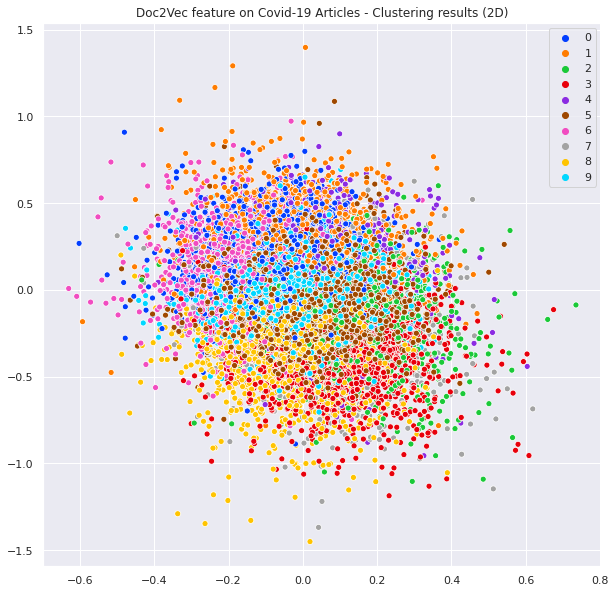

In [0]:
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.color_palette("bright", len(set(y_pred_doc2vec)))
sns.scatterplot(doc2vec_data[:,0], doc2vec_data[:,1], hue=y_pred_doc2vec, legend='full', palette=palette)
plt.title("Doc2Vec feature on Covid-19 Articles - Clustering results (2D)")
plt.show()

It looks like not so obvious, I will perform PCA to reduce the dimensionality, and visualize it again in 3D.

### Final results after going through PCA 

It is a statistical approach and uses an orthogonal transformation. Our text representation (such as bag of words, tf-idf, doc2vec) resprents text in the form of mutli dimensional matrix which involves a lot of features in the feature space. To address for dimension reduction, PCA can be used. It extract features (which is different from feature elimination) and reduce dimension.

In [0]:
pca = PCA(n_components=3).fit(doc2vec_data)
pca_doc2vec = pca.transform(doc2vec_data)
centroids =  pca.transform(kmeans_doc2vec.cluster_centers_)

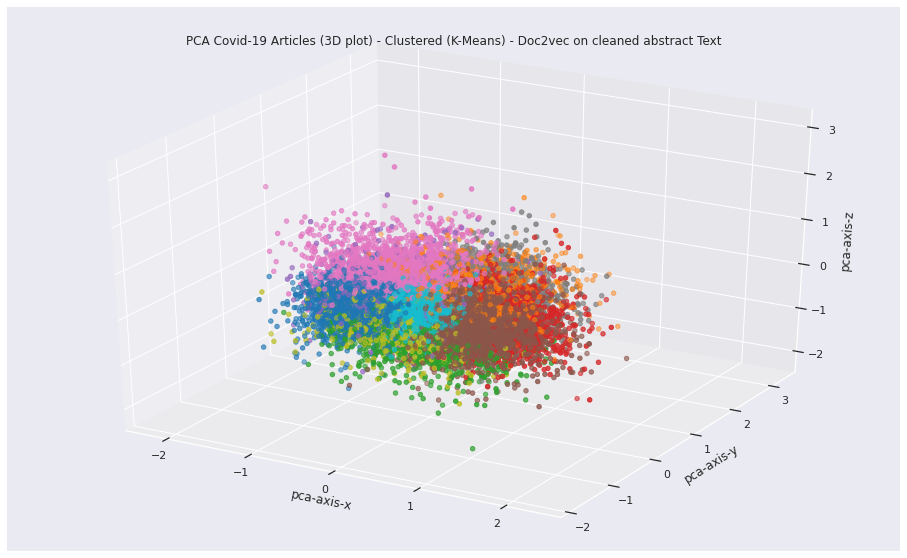

In [0]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(xs=pca_doc2vec[:,0], ys=pca_doc2vec[:,1], zs=pca_doc2vec[:,2], c=y_pred_doc2vec, cmap='tab10')
ax.set_xlabel('pca-axis-x')
ax.set_ylabel('pca-axis-y')
ax.set_zlabel('pca-axis-z')
plt.title("PCA Covid-19 Articles (3D plot) - Clustered (K-Means) - Doc2vec on cleaned abstract Text")
plt.show()

From the plot we can clearly see the k means algorithm divide the dataset into some clusters.

### Prepare Data for classification

Concat the label column and doc2vec features together, it will be our first dataset for multiclass classification task.

In [0]:
label_df = pd.DataFrame(kmeans_doc2vec.labels_)
label_df.columns = ['labels']
doc2vec_data = pd.concat([label_df,doc2vec_features],axis=1)
doc2vec_data.head()

,labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,0.056620,0.255261,0.032520,0.086884,0.258996,-0.115424,-0.208052,-0.287485,0.519751,0.240483,0.154163,-0.077798,-0.007952,-0.076399,-0.166650,-0.119795,-0.281718,0.359973,0.253710,-0.238584,0.439430,-0.337459,0.086046,0.016386,0.109176,-0.072759,0.098123,-0.368491,0.078640,0.415013,-0.307584,-0.064409,-0.320885,0.037863,0.050513,0.157273,-0.171270,0.139525,-0.173258,...,-0.031381,-0.027929,-0.205987,0.084008,0.055309,0.069894,0.015090,0.022372,-0.187977,-0.137359,0.135716,-0.145145,0.219073,-0.000818,-0.207902,-0.074525,-0.164030,0.101146,-0.053108,0.045662,0.169784,-0.010772,-0.097630,-0.093456,0.191239,0.012607,-0.088380,0.212192,0.066242,-0.277571,-0.143119,-0.188478,0.186016,0.122707,-0.265834,0.188850,0.165816,-0.293353,0.280396,-0.001592
1,5,-0.088456,0.166744,0.210955,-0.045630,0.036043,0.023745,0.671440,0.098650,-0.147050,0.061708,0.221195,0.082180,0.003315,0.106049,-0.382830,-0.029311,-0.084550,0.132824,0.431478,0.070202,0.040151,-0.063162,0.228186,0.048286,-0.231514,-0.268145,0.107808,-0.437047,-0.038794,0.245946,-0.114646,0.041647,-0.119291,-0.098327,-0.114004,-0.028984,-0.108480,0.101368,-0.244999,...,0.252960,-0.057687,0.069627,-0.066306,-0.002415,-0.044357,-0.149441,0.285904,-0.061006,0.023684,-0.124497,0.143210,0.029517,-0.277617,-0.398380,0.153644,-0.124725,-0.112769,-0.051397,0.011028,0.279482,0.010717,-0.008698,0.158119,-0.123661,-0.184449,-0.181987,-0.089847,-0.206513,-0.204166,0.096626,-0.217391,-0.050721,-0.080144,0.108087,0.202529,0.139179,-0.062108,-0.315463,0.077617
2,5,0.112996,-0.360566,0.106383,-0.193133,0.139478,-0.160411,0.227257,0.039650,0.114814,0.065543,-0.016006,-0.022184,-0.014782,-0.319477,0.038987,-0.106550,-0.069533,-0.047204,0.153959,0.359009,0.018135,0.196638,0.015465,0.067333,0.100469,0.365637,-0.101558,-0.304783,0.245566,0.015733,-0.072170,0.239421,-0.353813,-0.247557,-0.077866,0.128501,-0.021139,0.443619,-0.301082,...,0.270698,-0.213997,-0.115823,-0.653251,-0.383441,-0.252316,0.192650,0.374721,0.207313,0.099938,-0.188622,0.298254,0.008890,-0.259661,-0.206582,0.381951,0.079463,0.058465,0.100342,0.052418,0.256579,0.137616,-0.019561,0.419347,-0.142452,-0.335912,0.187939,0.143606,-0.357072,0.336732,0.373196,-0.241818,0.161636,0.043360,-0.008596,0.112038,0.198269,-0.114360,-0.158012,0.127958
3,2,0.081978,-0.033053,0.113370,0.158406,-0.000598,-0.067362,-0.110919,-0.151793,0.548175,0.335422,0.138574,-0.171307,0.169200,-0.171194,-0.256492,-0.101961,-0.286532,0.191766,0.102752,0.036439,0.514447,-0.528486,0.124906,0.053247,0.150133,-0.024316,-0.017437,-0.450468,0.240964,0.448474,-0.079471,0.056235,-0.353794,0.119176,0.057264,0.028404,-0.054042,0.416603,-0.168922,...,0.081267,0.030597,-0.115348,0.039271,0.108023,0.147867,0.050542,-0.008174,-0.273636,-0.274663,-0.094809,-0.011714,0.158232,-0.045266,-0.146646,0.002247,-0.082250,0.174310,-0.010203,-0.121980,0.366384,-0.007569,-0.185546,0.151939,-0.043137,-0.253261,-0.201672,0.355392,0.009035,-0.198862,-0.135493,-0.081926,0.031067,0.441962,-0.349745,0.171396,0.071618,-0.292769,0.024040,0.313742
4,8,-0.327166,-0.476083,-0.158832,-0.011582,0.052395,-0.161328,0.223456,0.012164,0.023160,0.035225,0.268012,-0.048131,-0.007158,0.205861,-0.128354,0.129425,-0.247480,0.092374,-0.031012,0.117723,0.216073,-0.292399,0.125974,0.167176,-0.116243,-0.068402,-0.001470,0.095890,-0.028648,0.487264,0.068070,-0.131503,-0.198930,0.002699,0.261374,0.008091,0.070798,0.371838,-0.111235,...,0.421317,0.186160,-0.021753,-0.312966,-0.238707,0.121885,-0.219197,0.179512,-0.227462,0.060764,0.112552,0.257830,0.091015,0.081684,-0.274943,0.250684,0.106821,0.221046,0.171500,0.043722,-0.054667,-0.040679,-0.040044,0.198345,-0.014703,-0.027962,-0.125410,0.244383,-0.239013,0.086934,0.073854,0.057752,-0.095687,0.291965,0.002345,0.045532,0.353327,-0.0326

In [0]:
doc2vec_data['labels'].value_counts()

9    8466
0    5991
5    3617
7    2836
3    2828
1    2686
8    2570
6    2403
2    2031
4    1381
Name: labels, dtype: int64

In [0]:
# doc2vec_data.to_csv('doc2vec.csv')

## TF-IDF features

The second type of feature used is called "Term Frequency-Inverse Document Frequency" (TF-IDF), it is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The idea here is that words that appears often are in fact not important; whereas, words that appear less frequent contribute more to the overall importance.

I set my max feature of tfidf be 800 due to my computer's computation ability. 

In [0]:
vectorizer = TfidfVectorizer(max_features=800)
tfidf_feature = vectorizer.fit_transform(df['abs_with_lemmer'].values)

### K-means clustering model

To keep it identical, I have set K = 10 as well.

In [0]:
kmeans_tfidf = KMeans(10)
y_pred_tfidf = kmeans_tfidf.fit_predict(tfidf_feature)
df['label_tfidf_kmeans'] = kmeans_tfidf.labels_

In [0]:
df.to_csv('LDA_tfidf_data.csv')

### Final results after Dimensionality reduction tool(PCA)

In [0]:
pca_tfidf = PCA(n_components=3).fit(tfidf_feature.toarray())
pca_tfidf_data = pca_tfidf.transform(tfidf_feature.toarray())
centroids_tfidf =  pca_tfidf.transform(kmeans_tfidf.cluster_centers_)

### Visualize results in 2D

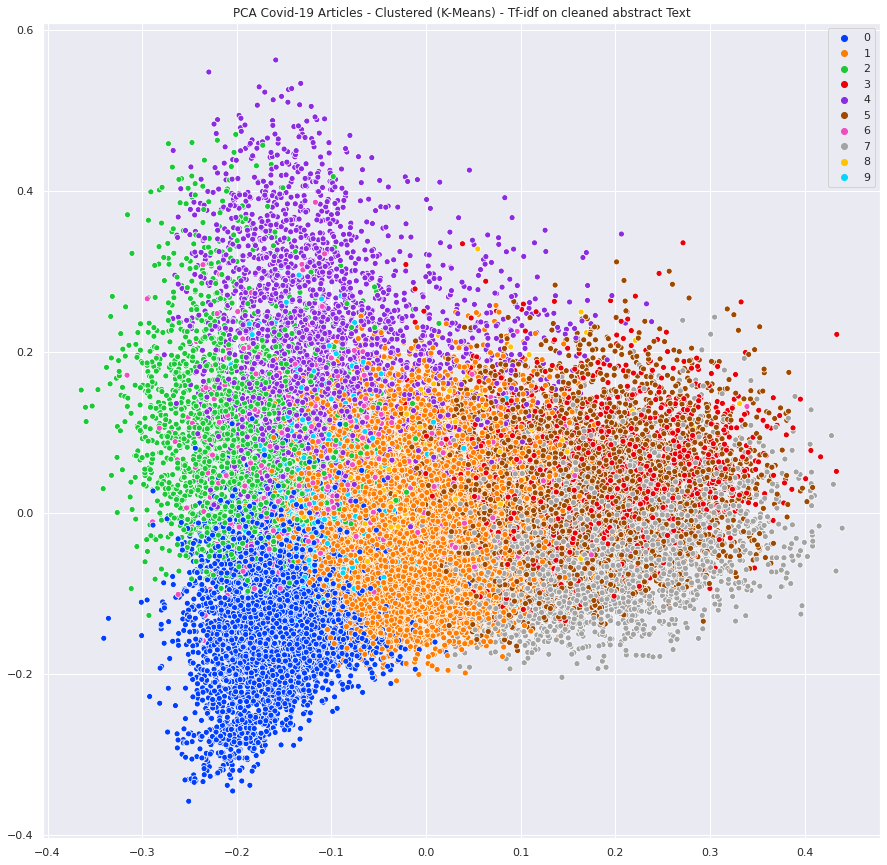

In [0]:
sns.set(rc={'figure.figsize':(15,15)})
palette = sns.color_palette("bright", len(set(y_pred_tfidf)))
sns.scatterplot(pca_tfidf_data[:,0], pca_tfidf_data[:,1], hue=y_pred_tfidf, legend='full', palette=palette)
plt.title("PCA Covid-19 Articles - Clustered (K-Means) - Tf-idf on cleaned abstract Text")
plt.show()

### Visualize in 3D

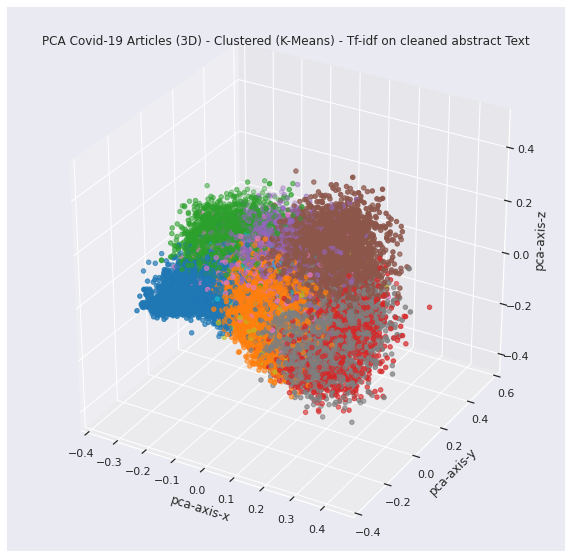

In [0]:
ax = plt.figure(figsize=(10,10)).gca(projection='3d')
ax.scatter(
    xs=pca_tfidf_data[:,0], 
    ys=pca_tfidf_data[:,1], 
    zs=pca_tfidf_data[:,2], 
    c=y_pred_tfidf, 
    cmap='tab10'
)
ax.set_xlabel('pca-axis-x')
ax.set_ylabel('pca-axis-y')
ax.set_zlabel('pca-axis-z')
plt.title("PCA Covid-19 Articles (3D) - Clustered (K-Means) - Tf-idf on cleaned abstract Text")

plt.show()

By using the tfidf feature, tfidf feature performed better than doc2vec because the clusters look like more compact and do not have too many overlaps.

### Prepare Data for classification

concat the label from kmeans and tfidf features together.

In [0]:
label_df = pd.DataFrame(kmeans_tfidf.labels_)
label_df.columns = ['labels']
TFIDF_features = pd.DataFrame(data=tfidf_feature.toarray(), columns = vectorizer.get_feature_names())

tfidf_data = pd.concat([label_df,TFIDF_features],axis=1)
tfidf_data.head()

,labels,10,100,11,12,13,14,15,16,17,18,20,2003,2009,2019,2019ncov,2020,21,24,25,30,50,95,ability,able,absence,abstract,according,ace2,acid,across,action,activation,active,activity,acute,addition,additional,adenovirus,administration,...,unknown,upon,upper,useful,user,vaccination,vaccine,value,variable,variant,variation,variety,various,vector,via,viral,virion,virus,vitro,vivo,week,weight,well,western,whereas,whether,wild,wildtype,within,without,work,worker,world,worldwide,would,wuhan,year,yet,young,zoonotic
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.112728,0.0,0.0,0.098114,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.143784,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.215775,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110717,0.0,0.0,0.0,0.0,0.0,0.0,0.109066,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.115663,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.083254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.095971,0.107467,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.101311,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.094248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.074360,0.000000,0.0,0.0,0.144945,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.117747,0.0,0.030743,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.057991,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
tfidf_data['labels'].value_counts()

1    11055
0     5586
5     5418
7     3719
4     3034
2     2593
3     1825
6      760
8      458
9      361
Name: labels, dtype: int64

In [0]:
# tfidf_data.to_csv('tfidf.csv')

## Classification models

**The reason why I decided to use three classification models to predict the label because I want to find out which vectorization method is better.**

Read pervious two numerical datasets which contains the data and lables for 10 classes.

In [0]:
# load the meta data from the CSV file 
doc2vec_data=pd.read_csv('doc2vec.csv')
tfidf_data=pd.read_csv('tfidf.csv')

Below is the function to generate confusion matrix plot, which is used to evaluate model classification results.

In [0]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, fs=(12,12),font_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=fs);
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=font_size)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=font_size-2)
    plt.xlabel('Predicted label', fontsize=font_size-2)
    plt.tight_layout()

### Preparing Testing and Training Data

In [0]:
# Split test (30%) and train (70%) data for doc2vec features
X_doc2vec = doc2vec_data.drop(['labels'], axis=1)
y_doc2vec = doc2vec_data['labels']
X_doc2vec_train, X_doc2vec_test, y_doc2vec_train, y_doc2vec_test = train_test_split(X_doc2vec, y_doc2vec, random_state=40, test_size=0.3)

# Split test (30%) and train (70%) data for TF-IDF features
X_tfidf = tfidf_data.drop(['labels',], axis=1)
y_tfidf = tfidf_data['labels']
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y_tfidf, random_state=55, test_size=0.3)

### Logistic Regression

I implemented the Logistic Regression model for both features created before(doc2vec and tf-idf), trained on the training dataset, and then applied the model to the testing dataset to obtain an accuracy value. 

**Pros:**
*   Convenient probability scores for observations
*   Multi-collinearity is not really an issue and can be countered with L2 regularization to an extent
*   popular classification model

**Cons:**
*   Doesn’t perform well when feature space is too large
*   Relies on entire data
*   Doesn’t handle large number of categorical features/variables well

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
log_model_doc2vec = LogisticRegression(penalty='l2',C=0.5, solver='liblinear',multi_class='ovr',n_jobs=-1)
log_model_doc2vec.fit(X_doc2vec_train, y_doc2vec_train)
LR_accuracy_doc2vec = log_model_doc2vec.score(X_doc2vec_test, y_doc2vec_test)
print("The accuracy of Logistic Regression Model on Doc2vec feature classification is :",LR_accuracy_doc2vec)

The accuracy of Logistic Regression Model on Doc2vec feature classification is : 0.5878578952408312


Cross Validation Accuracy: 0.60 (+/- 0.04)


              precision    recall  f1-score   support

           0       0.36      0.54      0.43      1793
           1       0.85      0.76      0.81       768
           2       1.00      0.04      0.08       611
           3       0.89      0.65      0.75       843
           4       0.91      0.67      0.77       401
           5       0.88      0.68      0.77      1087
           6       0.88      0.63      0.74       717
           7       0.93      0.66      0.78       856
           8       1.00      0.04      0.08       805
           9       0.47      0.76      0.58      2562

    accuracy                           0.59     10443
   macro avg       0.82      0.54      0.58     10443
weighted avg       0.71      0.59      0.57     10443



<Figure size 432x288 with 0 Axes>

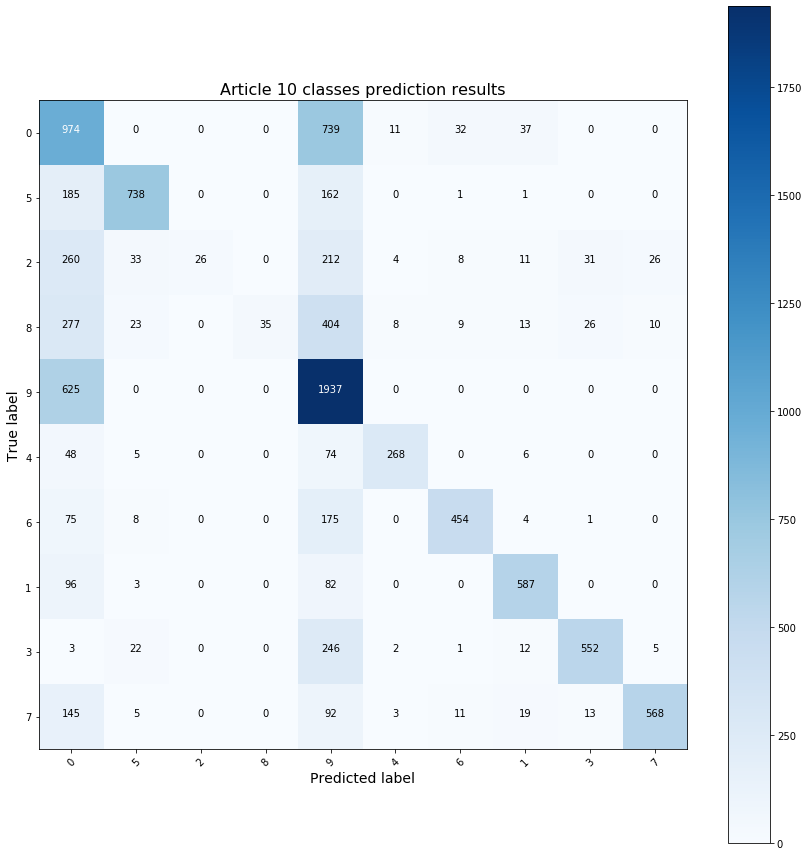

In [0]:
ticklabel=doc2vec_data.labels.unique()

log_predictions = log_model_doc2vec.predict(X_doc2vec_test)
log_predictions_series = pd.Series(log_predictions)
log_predictions_series = log_predictions_series.astype(int)

scores_multi = cross_val_score(log_model_doc2vec, X_doc2vec_train, y_doc2vec_train , cv=10)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print("\n")
cm=confusion_matrix(y_doc2vec_test, log_predictions_series, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Article 10 classes prediction results', fs=(12,12), font_size=16)


print(classification_report(y_doc2vec_test, log_predictions_series))

In [0]:
log_model_tfidf = LogisticRegression(penalty='l2',C=0.5, solver='liblinear',multi_class='ovr',n_jobs=-1)
log_model_tfidf.fit(X_tfidf_train, y_tfidf_train)
LR_accuracy_tfidf = log_model_tfidf.score(X_tfidf_test, y_tfidf_test)
print("The accuracy of Logistic Regression Model on tfidf feature 10 classes classification accuracy is :",LR_accuracy_tfidf)

The accuracy of Logistic Regression Model on tfidf feature 10 classes classification accuracy is : 0.31772479172651535


Cross Validation Accuracy: 0.33 (+/- 0.00)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1646
           1       0.31      1.00      0.48      3245
           2       0.00      0.00      0.00       784
           3       0.00      0.00      0.00       548
           4       0.00      0.00      0.00       992
           5       0.00      0.00      0.00      1646
           6       0.00      0.00      0.00       240
           7       0.00      0.00      0.00      1126
           8       0.00      0.00      0.00       118
           9       1.00      0.74      0.85        98

    accuracy                           0.32     10443
   macro avg       0.13      0.17      0.13     10443
weighted avg       0.11      0.32      0.16     10443



<Figure size 432x288 with 0 Axes>

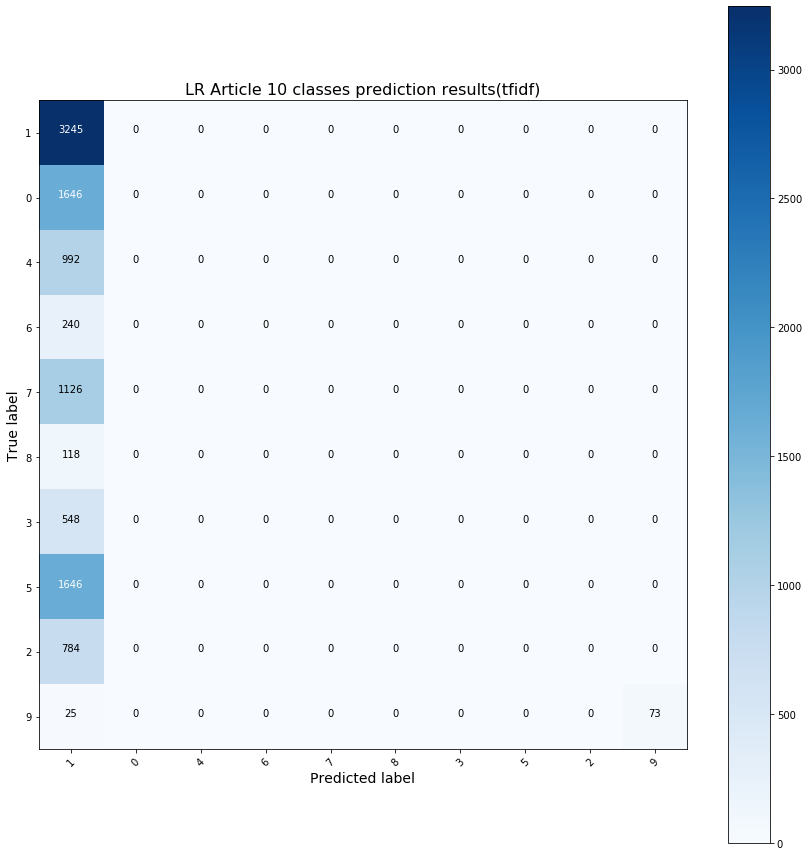

In [0]:
ticklabel=tfidf_data.labels.unique()

log_predictions = log_model_tfidf.predict(X_tfidf_test)
log_predictions_series = pd.Series(log_predictions)
log_predictions_series = log_predictions_series.astype(int)

scores_multi = cross_val_score(log_model_tfidf, X_tfidf_train, y_tfidf_train , cv=10)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print("\n")
cm=confusion_matrix(y_tfidf_test, log_predictions_series, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='LR Article 10 classes prediction results(tfidf)', fs=(12,12), font_size=16)


print(classification_report(y_tfidf_test, log_predictions_series))

Logistic regression model worked not so well, it only achieved 58% accuracy and 32% on doc2vec feature and tf-idf feature respectively.

### Decision Tree Model

**Pros:**
*   easy to interpret visually when the trees only contain several levels
*   Can easily handle qualitative (categorical) features
*   Works well with decision boundaries parellel to the feature axis


**Cons:**
*   prone to overfitting
*   possible issues with diagonal decision boundaries

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
# train the decision tree model
DT_doc2vec_model = DecisionTreeClassifier(random_state=0)
DT_doc2vec_model.fit(X_doc2vec_train, y_doc2vec_train)
DT_accuracy_doc2vec = DT_doc2vec_model.score(X_doc2vec_test, y_doc2vec_test)
print("The accuracy of Decision Tree Model(vec2doc feature) on covid-19 article 10 classes classification is :",DT_accuracy_doc2vec)

The accuracy of Decision Tree Model(vec2doc feature) on covid-19 article 10 classes classification is : 0.6570908742698458


Cross Validation Accuracy: 0.65 (+/- 0.03)


              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1793
           1       0.62      0.62      0.62       768
           2       0.56      0.56      0.56       611
           3       0.65      0.60      0.62       843
           4       0.54      0.55      0.54       401
           5       0.69      0.65      0.67      1087
           6       0.62      0.65      0.63       717
           7       0.65      0.62      0.64       856
           8       0.60      0.56      0.58       805
           9       0.67      0.70      0.69      2562

    accuracy                           0.66     10443
   macro avg       0.63      0.63      0.63     10443
weighted avg       0.66      0.66      0.66     10443



<Figure size 432x288 with 0 Axes>

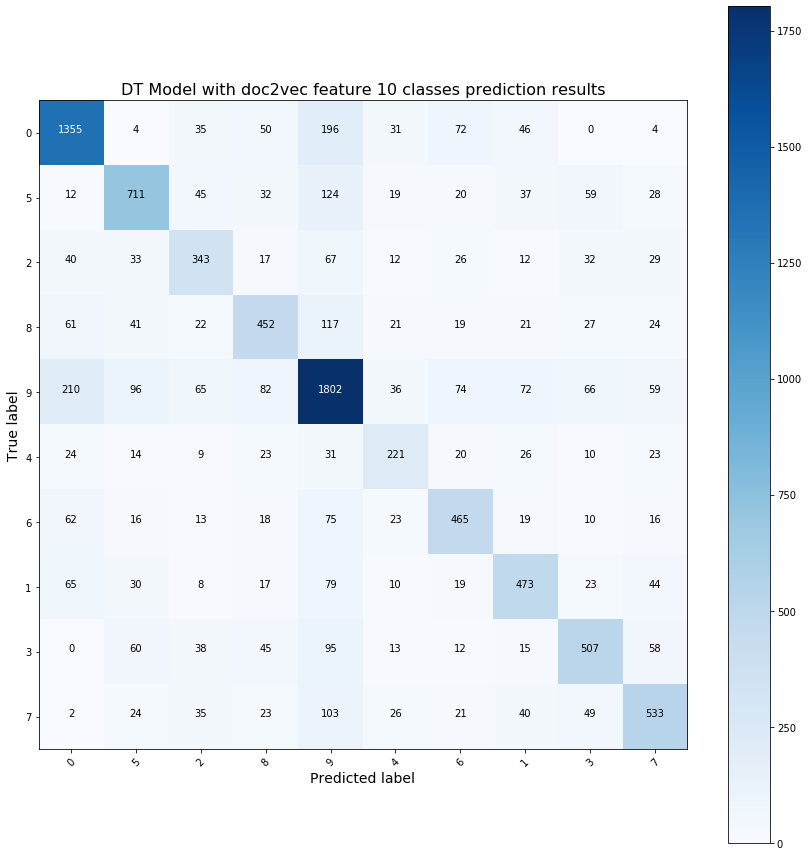

In [0]:
ticklabel=doc2vec_data.labels.unique()

log_predictions = DT_doc2vec_model.predict(X_doc2vec_test)
log_predictions_series = pd.Series(log_predictions)
log_predictions_series = log_predictions_series.astype(int)

scores_multi = cross_val_score(DT_doc2vec_model, X_doc2vec_train, y_doc2vec_train , cv=10)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print("\n")
cm=confusion_matrix(y_doc2vec_test, log_predictions_series, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='DT Model with doc2vec feature 10 classes prediction results', fs=(12,12), font_size=16)


print(classification_report(y_doc2vec_test, log_predictions_series))

In [0]:
# train the decision tree model
DT_tfidf_model = DecisionTreeClassifier(random_state=0)
DT_tfidf_model.fit(X_tfidf_train, y_tfidf_train)
DT_accuracy_tfidf = DT_tfidf_model.score(X_tfidf_test, y_tfidf_test)
print("The accuracy of Decision Tree Model(tfidf feature) on 10 classes article classification accuracy is :",DT_accuracy_tfidf)

The accuracy of Decision Tree Model(tfidf feature) on 10 classes article classification accuracy is : 0.7813846595805803


Cross Validation Accuracy: 0.77 (+/- 0.01)


              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1646
           1       0.77      0.77      0.77      3245
           2       0.83      0.84      0.84       784
           3       0.74      0.77      0.76       548
           4       0.78      0.74      0.76       992
           5       0.77      0.79      0.78      1646
           6       0.92      0.90      0.91       240
           7       0.77      0.74      0.76      1126
           8       0.92      0.92      0.92       118
           9       0.93      0.94      0.93        98

    accuracy                           0.78     10443
   macro avg       0.82      0.82      0.82     10443
weighted avg       0.78      0.78      0.78     10443



<Figure size 432x288 with 0 Axes>

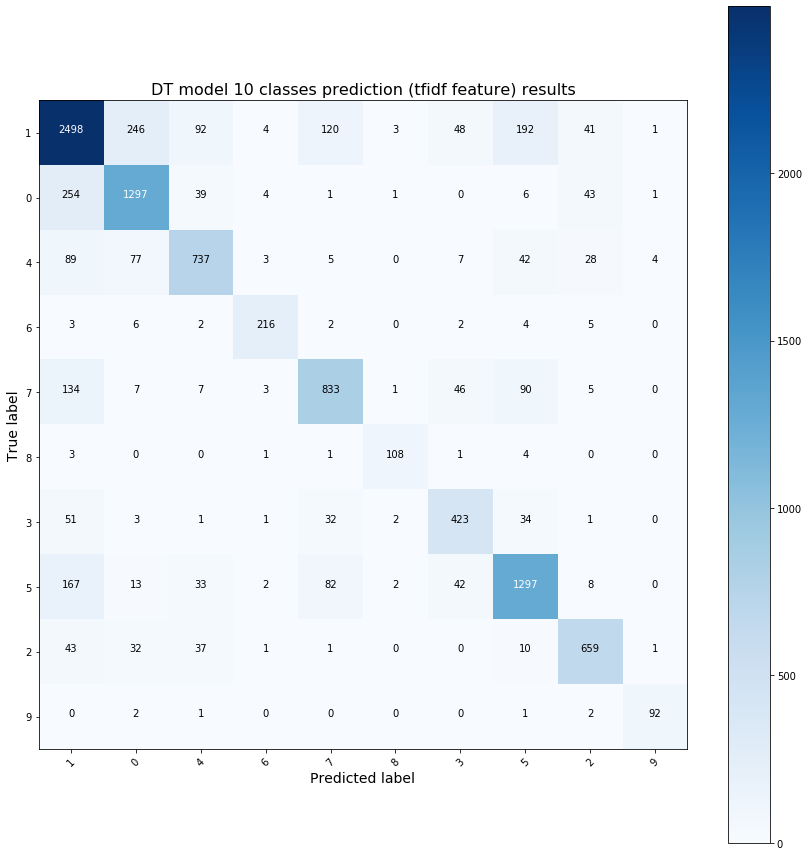

In [0]:
ticklabel=tfidf_data.labels.unique()

log_predictions = DT_tfidf_model.predict(X_tfidf_test)
log_predictions_series = pd.Series(log_predictions)
log_predictions_series = log_predictions_series.astype(int)

scores_multi = cross_val_score(DT_tfidf_model, X_tfidf_train, y_tfidf_train , cv=10)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print("\n")
cm=confusion_matrix(y_tfidf_test, log_predictions_series, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='DT model 10 classes prediction (tfidf feature) results', fs=(12,12), font_size=16)


print(classification_report(y_tfidf_test, log_predictions_series))

### XGBoost Model

**Pros:**
*   Somewhat more interpretable than bagged trees/random forest as the user can define the size of each tree resulting in a collection of stumps (1 level) which can be viewed as an additive model
*   Can easily handle qualitative (categorical) features

**Cons:**
*   Unlike bagging and random forests, can overfit if number of trees is too large

In [0]:
import xgboost as xgb

In [0]:
# train the XGBoost model
xgb_doc2vec_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42)
xgb_doc2vec_model.fit(X_doc2vec_train, y_doc2vec_train)
xgb_accuracy_doc2vec = xgb_doc2vec_model.score(X_doc2vec_test, y_doc2vec_test)
print("The accuracy of XGBoost Model on 10 classes article classification(doc2vec feature) is :",xgb_accuracy_doc2vec)

The accuracy of XGBoost Model on 10 classes article classification(doc2vec feature) is : 0.9098917935459159


Cross Validation Accuracy: 0.91 (+/- 0.01)


              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1793
           1       0.92      0.91      0.91       768
           2       0.90      0.88      0.89       611
           3       0.92      0.86      0.89       843
           4       0.93      0.89      0.91       401
           5       0.92      0.92      0.92      1087
           6       0.93      0.90      0.91       717
           7       0.91      0.90      0.91       856
           8       0.91      0.85      0.88       805
           9       0.88      0.94      0.91      2562

    accuracy                           0.91     10443
   macro avg       0.91      0.90      0.91     10443
weighted avg       0.91      0.91      0.91     10443



<Figure size 432x288 with 0 Axes>

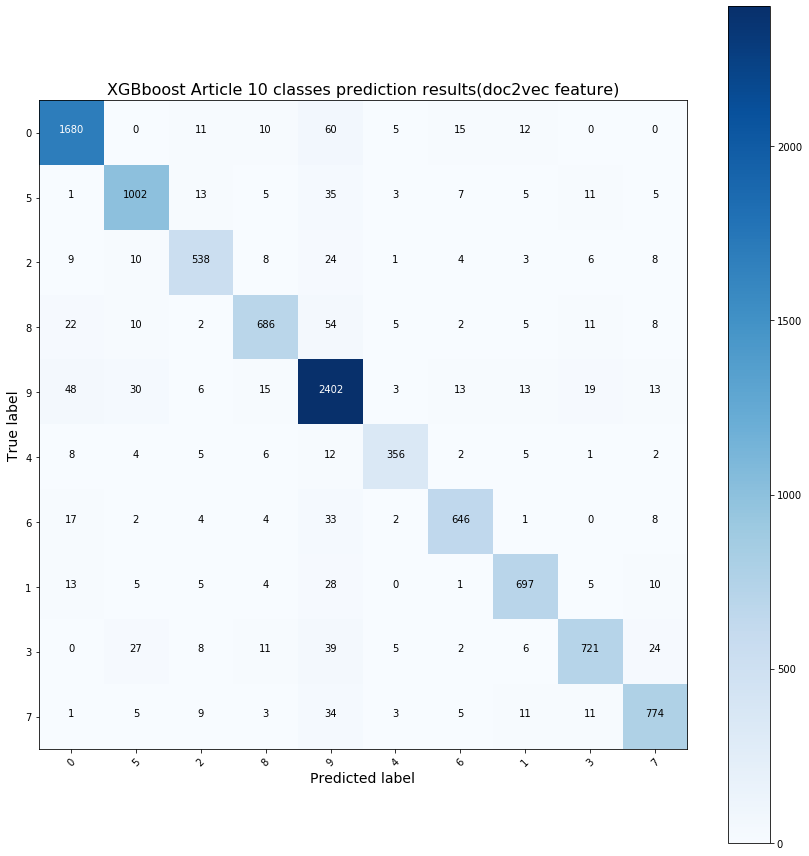

In [0]:
ticklabel=doc2vec_data.labels.unique()

log_predictions = xgb_doc2vec_model.predict(X_doc2vec_test)
log_predictions_series = pd.Series(log_predictions)
log_predictions_series = log_predictions_series.astype(int)

scores_multi = cross_val_score(xgb_doc2vec_model, X_doc2vec_train, y_doc2vec_train , cv=10)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print("\n")
cm=confusion_matrix(y_doc2vec_test, log_predictions_series, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='XGBboost Article 10 classes prediction results(doc2vec feature)', fs=(12,12), font_size=16)


print(classification_report(y_doc2vec_test, log_predictions_series))

In [0]:
# train the XGBoost model on tfidf feature

xgb_tfidf_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42)
xgb_tfidf_model.fit(X_tfidf_train, y_tfidf_train)
xgb_accuracy_tfidf = xgb_tfidf_model.score(X_tfidf_test, y_tfidf_test)
print("The accuracy of XGBoost Model on 10 classes article classification(tfidf feature) is :",xgb_accuracy_tfidf)

The accuracy of XGBoost Model on 10 classes article classification(tfidf feature) is : 0.9213827444221009


Cross Validation Accuracy: 0.92 (+/- 0.01)


              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1646
           1       0.90      0.93      0.91      3245
           2       0.93      0.90      0.91       784
           3       0.92      0.91      0.91       548
           4       0.93      0.90      0.92       992
           5       0.92      0.93      0.93      1646
           6       0.96      0.96      0.96       240
           7       0.93      0.92      0.92      1126
           8       0.99      0.97      0.98       118
           9       1.00      1.00      1.00        98

    accuracy                           0.92     10443
   macro avg       0.94      0.93      0.94     10443
weighted avg       0.92      0.92      0.92     10443



<Figure size 432x288 with 0 Axes>

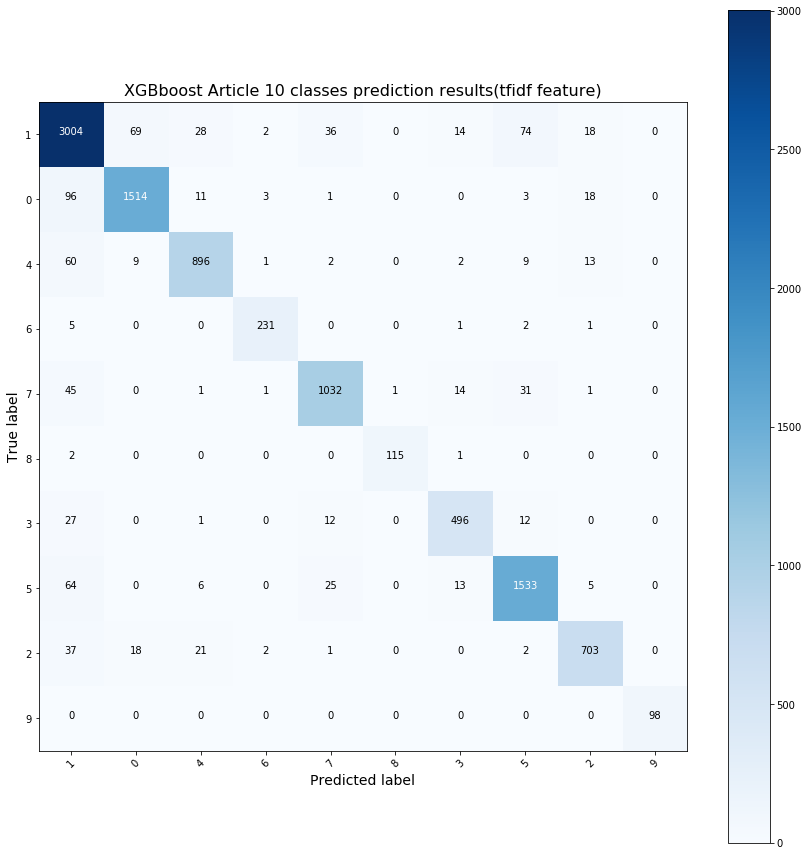

In [0]:
ticklabel=tfidf_data.labels.unique()

log_predictions = xgb_tfidf_model.predict(X_tfidf_test)
log_predictions_series = pd.Series(log_predictions)
log_predictions_series = log_predictions_series.astype(int)

scores_multi = cross_val_score(xgb_tfidf_model, X_tfidf_train, y_tfidf_train , cv=10)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print("\n")
cm=confusion_matrix(y_tfidf_test, log_predictions_series, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='XGBboost Article 10 classes prediction results(tfidf feature)', fs=(12,12), font_size=16)


print(classification_report(y_tfidf_test, log_predictions_series))

### Conclusion

In [0]:
model_name = np.array([['Logistic Regression'], ['Decision Tree'], ['XGBoost']])
doc2vec_accuracy = np.array([[round(LR_accuracy_doc2vec*100, 3)], [round(DT_accuracy_doc2vec*100, 3)],[round(xgb_accuracy_doc2vec*100, 3)]])
tfidf_accuracy = np.array([[round(LR_accuracy_tfidf*100, 3)],[round(DT_accuracy_tfidf*100, 3)],[round(xgb_accuracy_tfidf*100, 3)]])  
result_np = np.concatenate((model_name, doc2vec_accuracy, tfidf_accuracy), axis=1) 
Result = pd.DataFrame(result_np)
Result.columns = ['model', 'doc2vec', 'tf-idf']
Result

,model,doc2vec,tf-idf
0,Logistic Regression,58.786,31.772
1,Decision Tree,65.709,78.138
2,XGBoost,90.989,92.138


From above dataframe results, we can clearly see that XGBoost had highest accuracy on tf-idf features. Even though XGBoost model tfidf feature has highest score, doc2vec feature only 2% off in this case, they basically have same performance on XGBoost model. In addition, Decision tree model shows that tfidf is better, while logistic regression shows that tfidf is not an ideal feature. It hard to conclude which feature is obviously better here.

I decided to use **tfidf feature on LDA**, because it has high accuracy according results above, except logistic regression case.

# Unsupervised Leaning Model 2: Latent Dirichlet Allocation (LDA) Topic Modelling

If we simply perform Kmeans which will be meaning less since we only get desired number of clusters and nothing else. I will use another unsupervised learning model called Latent Dirichlet Allocation, which is specifically designed for topic modelling, once we have 10 clusters from kmeans, I will implement LDA to each one of cluster to find out the topic for each cluster.

I have self learned LDA implementation method and knowledge from the website below.

Reference website: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#11howtogridsearchthebestldamodel

**Topic Modeling** - Because we are given a huge dataset containing larger amount of research documents. At the document level, the most useful ways to understand text by its topics. The statistical process of learning and extracting these topics from huge amount of documents is called topic modeling.In Text Mining Topic Modeling is a technique to extract the hidden topics from huge amount of text.

Latent Dirichlet Allocation (LDA) is one of those popular algorithms for topic modeling. LDA is a form of unsupervised learning that views documents as bags of words (ie order does not matter). LDA works by first making a key assumption: the way a document was generated was by picking a set of topics and then for each topic picking a set of words. Each document can be described by a distribution of topics and each topic can be described by a distribution of words.

## Pros and cons for LDA

**Pros:**


*   LDA is a probabilistic model with interpretable topics. 
*   Easy to implement
*   it can be very useful as a preprocessing step in such a pipeline to extract information or features from your corpus.

**Cons:**


*   Does not have specific evaluation metric to measure it performance.
*   Like Kmeans, number of topic(k) is pre-decided by user.







## Implementation of LDA

read the file stored before, make each cluster data into a dataframe, by doing this we now have 10 cluster data ready for 10 LDA model. This can give us the topic of each cluster.

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

In [0]:
df=pd.read_csv('LDA_tfidf_data.csv')

In [0]:
df['label_tfidf_kmeans'].value_counts()

2    9615
8    5193
6    4741
3    4515
4    3326
5    3179
7    1755
1    1196
9     928
0     360
Name: label_tfidf_kmeans, dtype: int64

In [0]:
cluster_0_data = df[df['label_tfidf_kmeans']==0]
cluster_1_data = df[df['label_tfidf_kmeans']==1]
cluster_2_data = df[df['label_tfidf_kmeans']==2]
cluster_3_data = df[df['label_tfidf_kmeans']==3]
cluster_4_data = df[df['label_tfidf_kmeans']==4]
cluster_5_data = df[df['label_tfidf_kmeans']==5]
cluster_6_data = df[df['label_tfidf_kmeans']==6]
cluster_7_data = df[df['label_tfidf_kmeans']==7]
cluster_8_data = df[df['label_tfidf_kmeans']==8]
cluster_9_data = df[df['label_tfidf_kmeans']==9]

In [0]:
cluster_0_data = cluster_0_data.drop(['label_tfidf_kmeans','title','abstract','authors','abs_without_stopwords'],axis=1)
cluster_1_data = cluster_1_data.drop(['label_tfidf_kmeans','title','abstract','authors','abs_without_stopwords'],axis=1)
cluster_2_data = cluster_2_data.drop(['label_tfidf_kmeans','title','abstract','authors','abs_without_stopwords'],axis=1)
cluster_3_data = cluster_3_data.drop(['label_tfidf_kmeans','title','abstract','authors','abs_without_stopwords'],axis=1)
cluster_4_data = cluster_4_data.drop(['label_tfidf_kmeans','title','abstract','authors','abs_without_stopwords'],axis=1)
cluster_5_data = cluster_5_data.drop(['label_tfidf_kmeans','title','abstract','authors','abs_without_stopwords'],axis=1)
cluster_6_data = cluster_6_data.drop(['label_tfidf_kmeans','title','abstract','authors','abs_without_stopwords'],axis=1)
cluster_7_data = cluster_7_data.drop(['label_tfidf_kmeans','title','abstract','authors','abs_without_stopwords'],axis=1)
cluster_8_data = cluster_8_data.drop(['label_tfidf_kmeans','title','abstract','authors','abs_without_stopwords'],axis=1)
cluster_9_data = cluster_9_data.drop(['label_tfidf_kmeans','title','abstract','authors','abs_without_stopwords'],axis=1)

### tf-idf feature encode 10 clusters' data

Since we have 10 cluster data from previous data process part, now we need to vectorize the text by using tf-idf, the reason why I pick tfidf is because it performed better on multiclass classification task compared to doc2vec feature.

In [0]:
vectorizers = []
    
for _ in range(0, 10):
    # Creating 10 tfidf vectorizers
    vectorizers.append(TfidfVectorizer(max_df=0.8, min_df=2,max_features=400))

In [0]:
cluster0result = vectorizers[0].fit_transform(cluster_0_data['abs_with_lemmer'].values)
cluster1result = vectorizers[1].fit_transform(cluster_1_data['abs_with_lemmer'].values)
cluster2result = vectorizers[2].fit_transform(cluster_2_data['abs_with_lemmer'].values)
cluster3result = vectorizers[3].fit_transform(cluster_3_data['abs_with_lemmer'].values)
cluster4result = vectorizers[4].fit_transform(cluster_4_data['abs_with_lemmer'].values)
cluster5result = vectorizers[5].fit_transform(cluster_5_data['abs_with_lemmer'].values)
cluster6result = vectorizers[6].fit_transform(cluster_6_data['abs_with_lemmer'].values)
cluster7result = vectorizers[7].fit_transform(cluster_7_data['abs_with_lemmer'].values)
cluster8result = vectorizers[8].fit_transform(cluster_8_data['abs_with_lemmer'].values)
cluster9result = vectorizers[9].fit_transform(cluster_9_data['abs_with_lemmer'].values)

### Build LDA Model for each cluster

I have created a list which contains total 10 LDA models with same hyperparameters. Here I set **n_components = 5**, which means for each cluster, I should get 5 topics. The value of this hyperparameters is defined by user, I have tried different number of it, then it turns out 5 give us relevent good results.

In [0]:
lda_models = []#a list contain all 10 models

for _ in range(0, 10):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=5,           # Number of topics
                                      learning_decay=0.7,
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      n_jobs = -1,               # Use all available CPUs
                                     )
    lda_models.append(lda)

Then, each one of the LDA model fit into each tfidf vectorized cluster data

In [0]:
lda_c0_resultl = lda_models[0].fit_transform(cluster0result)
lda_c1_resultl = lda_models[1].fit_transform(cluster1result)
lda_c2_resultl = lda_models[2].fit_transform(cluster2result)
lda_c3_resultl = lda_models[3].fit_transform(cluster3result)
lda_c4_resultl = lda_models[4].fit_transform(cluster4result)
lda_c5_resultl = lda_models[5].fit_transform(cluster5result)
lda_c6_resultl = lda_models[6].fit_transform(cluster6result)
lda_c7_resultl = lda_models[7].fit_transform(cluster7result)
lda_c8_resultl = lda_models[8].fit_transform(cluster8result)
lda_c9_resultl = lda_models[9].fit_transform(cluster9result)

### The top 10 words from the 5 topics under cluster 0

visualize the top 10 words under each topic, combine them into dataframe.

In [0]:
dict_topic = {'topic_number_tfidf': [], 'topic_words_tfidf': []}

for i,topic in enumerate(lda_models[0].components_):
    dict_topic['topic_number_tfidf'].append(i)
    dict_topic['topic_words_tfidf'].append([vectorizers[0].get_feature_names()[i] for i in topic.argsort()[-10:]])

cluster0_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number_tfidf', 'topic_words_tfidf'])
cluster0_topics_tfidf.head(10)

,topic_number_tfidf,topic_words_tfidf
0,0,"[infecciones, para, por, que, virus, con, se, ..."
1,1,"[ranimation, elle, une, par, galement, cause, ..."
2,2,"[could, molecular, virus, form, emerging, sour..."
3,3,"[pour, par, infection, du, est, sont, dans, vi..."
4,4,"[por, diagnstico, los, viral, que, le, la, inf..."


### The top 10 words from the 5 topics under cluster 1

In [0]:
dict_topic = {'topic_number': [], 'topic_words_tfidf': []}

for i,topic in enumerate(lda_models[1].components_):
    dict_topic['topic_number'].append(i)
    dict_topic['topic_words_tfidf'].append([vectorizers[1].get_feature_names()[i] for i in topic.argsort()[-10:]])

cluster1_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number', 'topic_words_tfidf'])
cluster1_topics_tfidf.head(10)

,topic_number,topic_words_tfidf
0,0,"[bat, expression, antiviral, interferon, innat..."
1,1,"[respiratory, binding, cov, novel, coronavirus..."
2,2,"[analysis, genome, reservoir, coronaviruses, h..."
3,3,"[antibody, virus, syndrome, protein, camel, in..."
4,4,"[east, middle, transmission, outbreak, arabia,..."


### The top 10 words from the 5 topics under cluster 2

In [0]:
dict_topic = {'topic_number': [], 'topic_words_tfidf': []}

for i,topic in enumerate(lda_models[2].components_):
    dict_topic['topic_number'].append(i)
    dict_topic['topic_words_tfidf'].append([vectorizers[2].get_feature_names()[i] for i in topic.argsort()[-10:]])

cluster2_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number', 'topic_words_tfidf'])
cluster2_topics_tfidf.head(10)

,topic_number,topic_words_tfidf
0,0,"[diagnostic, dna, method, test, sensitivity, p..."
1,1,"[isolates, pig, analysis, ibv, dog, genome, ge..."
2,2,"[peptide, protease, drug, sarscov, feline, ant..."
3,3,"[therapeutic, clinical, abstract, application,..."
4,4,"[disease, animal, abstract, day, rat, infectio..."


### The top 10 words from the 5 topics under cluster 3

In [0]:
dict_topic = {'topic_number': [], 'topic_words_tfidf': []}

for i,topic in enumerate(lda_models[3].components_):
    dict_topic['topic_number'].append(i)
    dict_topic['topic_words_tfidf'].append([vectorizers[3].get_feature_names()[i] for i in topic.argsort()[-10:]])

cluster3_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number', 'topic_words_tfidf'])
cluster3_topics_tfidf.head(10)

,topic_number,topic_words_tfidf
0,0,"[clinical, acute, pneumonia, therapy, care, re..."
1,1,"[value, significantly, protein, pneumonia, gro..."
2,2,"[sari, odds, factor, ratio, confidence, interv..."
3,3,"[outbreak, day, syndrome, ct, sarscov2, severe..."
4,4,"[detected, human, sample, rsv, viral, influenz..."


### The top 10 words from the 5 topics under cluster 4

In [0]:
dict_topic = {'topic_number': [], 'topic_words_tfidf': []}

for i,topic in enumerate(lda_models[4].components_):
    dict_topic['topic_number'].append(i)
    dict_topic['topic_words_tfidf'].append([vectorizers[4].get_feature_names()[i] for i in topic.argsort()[-10:]])

cluster4_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number', 'topic_words_tfidf'])
cluster4_topics_tfidf.head(10)

,topic_number,topic_words_tfidf
0,0,"[animal, infection, sequence, specie, disease,..."
1,1,"[viral, region, synthesis, replication, struct..."
2,2,"[cellular, activity, protein, rna, host, cell,..."
3,3,"[rna, vector, silencing, expression, interfere..."
4,4,"[titer, human, pandemic, strain, iav, h5n1, ha..."


### The top 10 words from the 5 topics under cluster 5

In [0]:
dict_topic = {'topic_number': [], 'topic_words_tfidf': []}

for i,topic in enumerate(lda_models[5].components_):
    dict_topic['topic_number'].append(i)
    dict_topic['topic_words_tfidf'].append([vectorizers[5].get_feature_names()[i] for i in topic.argsort()[-10:]])

cluster5_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number', 'topic_words_tfidf'])
cluster5_topics_tfidf.head(10)

,topic_number,topic_words_tfidf
0,0,"[tgev, coronavirus, serum, ace2, spike, recomb..."
1,1,"[peptide, receptor, domain, glycoprotein, cell..."
2,2,"[chain, recognition, signaling, dna, degradati..."
3,3,"[mrna, sequence, infection, rna, expression, r..."
4,4,"[structural, site, enzyme, activity, sequence,..."


### The top 10 words from the 5 topics under cluster 6

In [0]:
dict_topic = {'topic_number': [], 'topic_words_tfidf': []}

for i,topic in enumerate(lda_models[6].components_):
    dict_topic['topic_number'].append(i)
    dict_topic['topic_words_tfidf'].append([vectorizers[6].get_feature_names()[i] for i in topic.argsort()[-10:]])

cluster6_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number', 'topic_words_tfidf'])
cluster6_topics_tfidf.head(10)

,topic_number,topic_words_tfidf
0,0,"[entry, activity, gene, apoptosis, line, prote..."
1,1,"[function, prrsv, pathogen, innate, review, ho..."
2,2,"[nervous, response, cd4, mhv, virus, infection..."
3,3,"[activation, expression, antiviral, signaling,..."
4,4,"[severe, epithelial, sars, influenza, airway, ..."


### The top 10 words from the 5 topics under cluster 7

In [0]:
dict_topic = {'topic_number': [], 'topic_words_tfidf': []}

for i,topic in enumerate(lda_models[7].components_):
    dict_topic['topic_number'].append(i)
    dict_topic['topic_words_tfidf'].append([vectorizers[7].get_feature_names()[i] for i in topic.argsort()[-10:]])

cluster7_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number', 'topic_words_tfidf'])
cluster7_topics_tfidf.head(10)

,topic_number,topic_words_tfidf
0,0,"[viral, strain, response, human, infection, de..."
1,1,"[mucosal, dna, immune, antigen, sarscov, prote..."
2,2,"[application, antibody, delivery, antigen, hiv..."
3,3,"[type, virus, pandemic, dna, nanoparticles, hu..."
4,4,"[neutralization, mab, binding, zikv, mabs, hiv..."


### The top 10 words from the 5 topics under cluster 8

In [0]:
dict_topic = {'topic_number': [], 'topic_words_tfidf': []}

for i,topic in enumerate(lda_models[8].components_):
    dict_topic['topic_number'].append(i)
    dict_topic['topic_words_tfidf'].append([vectorizers[8].get_feature_names()[i] for i in topic.argsort()[-10:]])

cluster8_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number', 'topic_words_tfidf'])
cluster8_topics_tfidf.head(10)

,topic_number,topic_words_tfidf
0,0,"[2003, outbreak, human, mers, severe, virus, a..."
1,1,"[epidemic, novel, sarscov2, 2020, 2019, 2019nc..."
2,2,"[risk, population, infection, infectious, outb..."
3,3,"[medical, knowledge, questionnaire, school, hy..."
4,4,"[surveillance, emergency, infectious, global, ..."


### The top 10 words from the 5 topics under cluster 9

In [0]:
dict_topic = {'topic_number': [], 'topic_words_tfidf': []}

for i,topic in enumerate(lda_models[9].components_):
    dict_topic['topic_number'].append(i)
    dict_topic['topic_words_tfidf'].append([vectorizers[9].get_feature_names()[i] for i in topic.argsort()[-10:]])

cluster9_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number', 'topic_words_tfidf'])
cluster9_topics_tfidf.head(10)

,topic_number,topic_words_tfidf
0,0,"[colostrum, bovine, fed, dairy, rotavirus, sam..."
1,1,"[outbreak, epidemic, gene, diarrhea, porcine, ..."
2,2,"[sequence, morbidity, gene, animal, virus, dia..."
3,3,"[spread, 2013, virus, positive, negative, outb..."
4,4,"[diarrhea, viral, porcine, protein, pig, infec..."


### Visualize Topic Modelling Results

**Note:** I only visualized one cluster (cluster 1) topics as an example, I am not going to visualize all 10 clusters' topics.

In [0]:
!pip install gensim
!pip install pyLDAvis

In [0]:
import pyLDAvis
import pyLDAvis.sklearn

In [0]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_models[1], cluster1result, vectorizers[1], mds='tsne', sort_topics=False)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      -52.454159 -288.555420       1        1   5.313965
1     -159.661499  -20.391693       2        1   3.152412
2       42.567165  200.703217       3        1  33.887735
3      230.797913  -19.450590       4        1  38.057651
4      246.515152 -308.649475       5        1  19.588238, topic_info=    Category        Freq          Term       Total  loglift  logprob
39   Default  147.000000           bat  147.000000  30.0000  30.0000
222  Default  145.000000       merscov  145.000000  29.0000  29.0000
48   Default   45.000000          cell   45.000000  28.0000  28.0000
307  Default   30.000000      response   30.000000  27.0000  27.0000
170  Default   24.000000        immune   24.000000  26.0000  26.0000
168  Default   19.000000           ifn   19.000000  25.0000  25.0000
28   Default   22.000000     antiviral   22.000000  24.0000  24.0000
262  Default   15.000000         plpro   15.000000  23.0000  23.0000
184  Default   14.000000        innate   14.000000  22.0000  22.0000
252  Default   41.000000       patient   41.000000  21.0000  21.0000
187  Default   12.000000    interferon   12.000000  20.0000  20.0000
132  Default   14.000000    expression   14.000000  19.0000  19.0000
12   Default   17.000000      activity   17.000000  18.0000  18.0000
323  Default   25.000000         saudi   25.000000  17.0000  17.0000
390  Default   41.000000         viral   41.000000  16.0000  16.0000
341  Default   43.000000        specie   43.000000  15.0000  15.0000
179  Default   67.000000     infection   67.000000  14.0000  14.0000
161  Default   38.000000          host   38.000000  13.0000  13.0000
30   Default   23.000000        arabia   23.000000  12.0000  12.0000
279  Default   37.000000       protein   37.000000  11.0000  11.0000
383  Default   13.000000          type   13.000000  10.0000  10.0000
251  Default    9.000000       pathway    9.000000   9.0000   9.0000
215  Default   14.000000        mammal   14.000000   8.0000   8.0000
153  Default   16.000000    healthcare   16.000000   7.0000   7.0000
219  Default   14.000000     mechanism   14.000000   6.0000   6.0000
364  Default   14.000000        system   14.000000   5.0000   5.0000
299  Default   16.000000   replication   16.000000   4.0000   4.0000
207  Default   11.000000          line   11.000000   3.0000   3.0000
386  Default   11.000000        unique   11.000000   2.0000   2.0000
223  Default   42.000000        middle   42.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
220   Topic5    6.347091       medical    8.830161   1.3001  -5.2802
362   Topic5    9.213469       symptom   13.281321   1.2645  -4.9076
74    Topic5   12.392513       contact   18.042390   1.2546  -4.6111
236   Topic5    7.362611      negative   10.861736   1.2414  -5.1318
243   Topic5    6.835299      occurred   10.272042   1.2229  -5.2061
36    Topic5    5.478531  asymptomatic    8.773226   1.1594  -5.4274
98    Topic5    6.002468     diagnosis   10.281858   1.0920  -5.3361
169   Topic5    8.114295       illness   13.953708   1.0881  -5.0346
86    Topic5    7.895156           day   13.880817   1.0660  -5.0620
301   Topic5   15.128115      reported   26.619206   1.0652  -4.4117
198   Topic5    7.705481    laboratory   13.574202   1.0640  -5.0863
64    Topic5    5.820644     community   10.478892   1.0423  -5.3668
314   Topic5   11.223354          risk   20.618548   1.0220  -4.7102
245   Topic5   17.677090      outbreak   33.993664   0.9763  -4.2560
75    Topic5   11.686178       control   21.631460   1.0145  -4.6698
222   Topic5   54.498053       merscov  145.822018   0.6460  -3.1301
381   Topic5   16.889646  transmission   40.205982   0.7629  -4.3015
179   Topic5   24.296617     infection   67.491983   0.6086  -3.9379
223   Topic5   15.546576        middle   42.446873   0.6258  -4.3844
117   Topic5   15.358246        

# Deriving insights about policy and guidance to tackle the outbreak based on previous findings.

## Exploratory Data Analysis findings and possible suggestions:

From my EDA part, it looks like covid-19 and other similar viruses mainly causes respiratory illness (like the flu) with symptoms such as a cough, fever, most likely(from the bar chart). According to the affect organ analysis, spleen, lungs, bronchi, liver are the organs for covid-19 and other viruses mainly attack, thus, respiratory system would be affected most due to covid-19. Based on above two analysis results, public cannot do much about Virus characteristics like these, I would recommend government and related organizations should **provide as much as possible medical responses**, like provide sufficient amount of ventilators to hospital, provide enough medical supplies, such as nucleic acid testings, medical protective suits...etc. Becasue failure to treat patients in time may lead to outbreaks.

Another anaysis I did in EDA shows that typically incubation time of covid-19 is around 0-20 days, thus, healthcare professionals, industry and governments should declear a **mandatory isolation term** for public, people should self-isolation two weeks after getting close to possible sources of infection.

Also, the last analysis I did is about possible causes of transmission, it showed that human-to-human and influenza, that is the virus is mostly transmitted via coughing, sneezing. Apart from it, its mainly transmitted via hosts (animal) dogs, bats. Based on these findings, I would recommend  healthcare professionals, industry and governments **provide enough media propaganda to pulic**, letting them know how this virus be transimitted to each other, by doing this, it should improve national health awareness a lot, further lower the risk of infection. 

Also, becuase covid-19 mainly transimitted by human to human, coughing, sneezing (see findings from EDA part), I strongly recommend people should **wear face mask, wash hands** to protect ourself.


## NLP Model conclusion:

Over 47,000 scholarly articles, including over 36,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses been provided, based on this avaliable dataset, I have successfully clustered the dataset into 10 groups by using an unsupervised learning model: K-means. Each cluster contains similar articles. Furthermore, I implemented Latent Dirichlet Allocation model, which is used to perform topic modelling task. Using LDA on these 10 clusters, I found out 5 most dominate topics for each cluster, and visualized top 10 words under each topic. So my approch basically help researchers and whoever wants to use this dataset, to make it easier for health professionals to find relevant research articles.

I got the labels from k-means, without any meaning to them. We use Topic Modeling on each cluster to get the keywords in order to put more meaning to each cluster. Finally, we do a manual analysis of each cluster to see what articles cluster together. However, the last step seems not really clear from my output, for now it is hard to make conclusion which cluster belongs to what topic, but hopefully can get some insights from the top 10 key words for each topic, it should be further improved by more sophsiticated data processing and vectorizing techniques, as well as hyperparameter tuning on kmeans and LDA. For model implementation part, there is currently no more exploratory analysis performed.
